#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/27/2017
Updated to use the compound data corrected for extraction efficiency for all compounds.

In [1]:
if False:
    #this will work to reload whatever I had
    import dill
    dill.load_session('globalsave.pkl')

In [1]:
if True:
    %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [99]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb
from sklearn import preprocessing
import seaborn as sns

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [3]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.04.27_v1.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabData.head()

,mtabNames,extEff,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,,,
C00196,2-3-dihydroxybenzoic acid,100.9,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,2-3-dihydroxypropane1sulfonate,0.6,1.500000e-09,0.0,7.560000e-09,0.000000e+00,8.830000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,3-mercapto proprionate,88.6,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,3-methyl-2-oxobutanoic acid,10.1,1.490000e-06,0.0,1.260000e-06,1.700000e-06,3.660000e-08,1.370000e-05,1.170000e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,3-methyl-2-oxopentanoic acid,50.1,0.000000e+00,0.0,1.150000e-07,2.140000e-07,0.000000e+00,6.080000e-07,6.060000e-07,1.500000e-09,1.230000e-09,2.170000e-09,1.410000e-10,2.190000e-09


In [4]:
#take out the extra columns: 
mtabData.drop(['extEff','mtabNames'],axis = 1,inplace = True)
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,1.500000e-09,0.0,7.560000e-09,0.000000e+00,8.830000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,1.490000e-06,0.0,1.260000e-06,1.700000e-06,3.660000e-08,1.370000e-05,1.170000e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,0.000000e+00,0.0,1.150000e-07,2.140000e-07,0.000000e+00,6.080000e-07,6.060000e-07,1.500000e-09,1.230000e-09,2.170000e-09,1.410000e-10,2.190000e-09


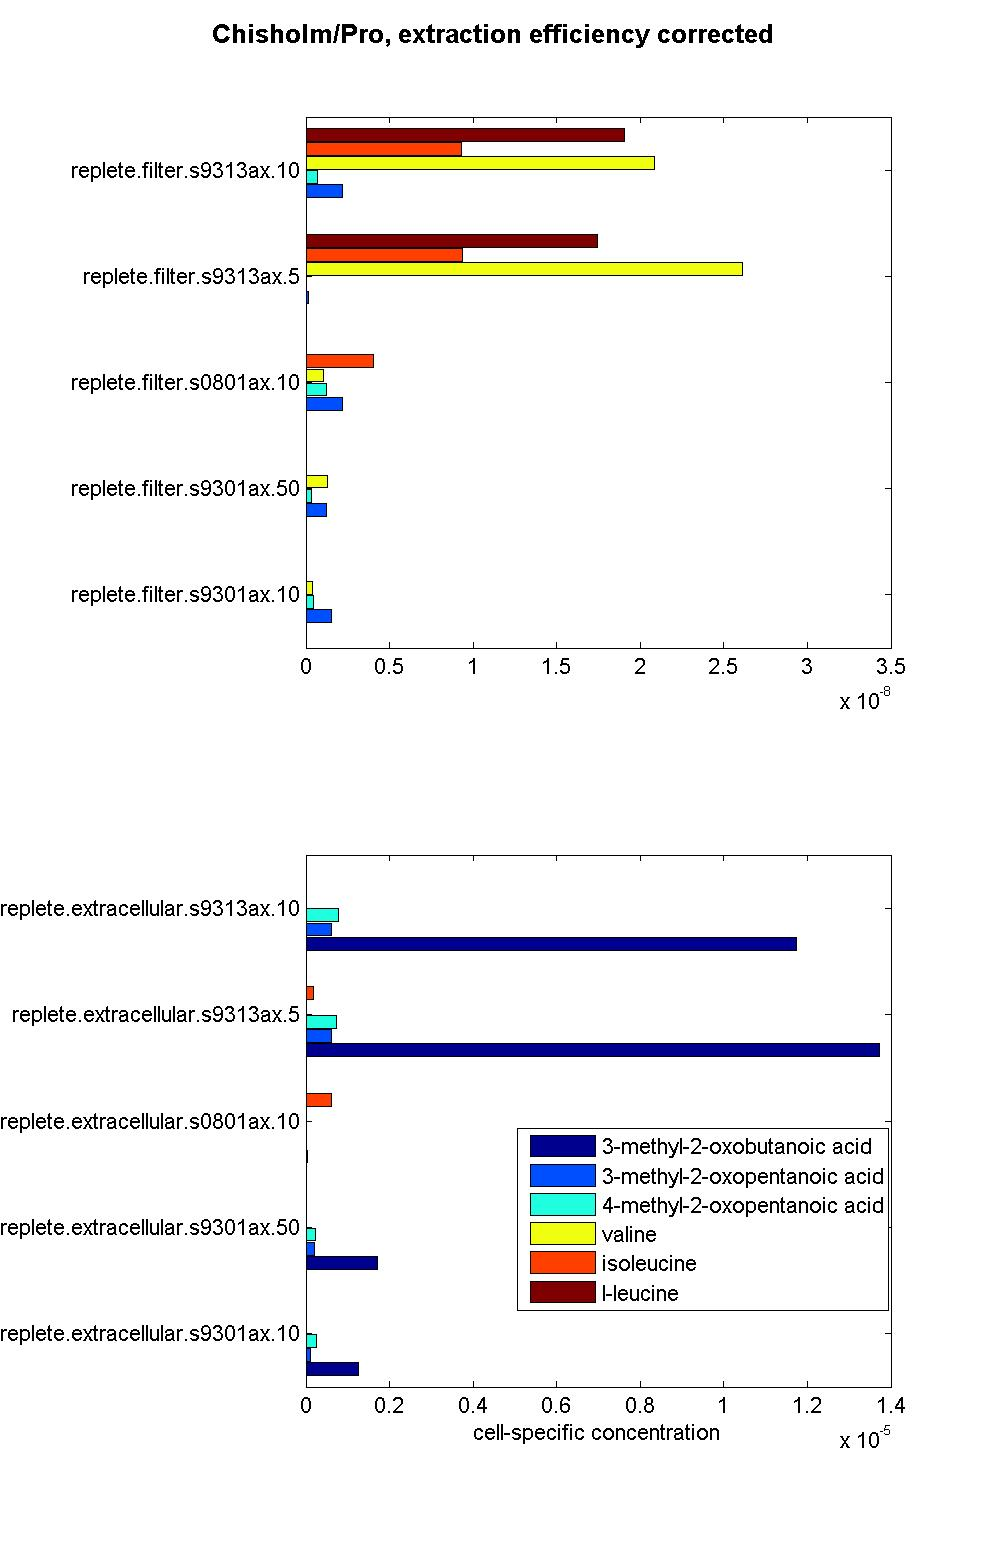

In [5]:
#read in the bar graph with the new acids (from MATLAB)
from IPython.display import Image
Image("Chisholm_Pro_newAcids.2017.04.27.jpg",width=300, height=300)

Setup a few useful functions
***

In [6]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [7]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [8]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [9]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [10]:
#bring in the plotting functions
import plotByGroup
import fxn_plotPathway
##if I make a change, have to reload the function(s):
# reload(fxn_plotPathway)

In [11]:
#go read in the file from KEGG
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 4/18/2017
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof)
    
prunedBRITE = allBRITE.dropna()
prunedBRITE.head()

,map,A,B,C,wholeThing
10,01100,Metabolism,Global and overview maps,Metabolic pathways,C 01100 Metabolic pathways\n
11,01110,Metabolism,Global and overview maps,Biosynthesis of secondary metabolites,C 01110 Biosynthesis of secondary metaboli...
12,01120,Metabolism,Global and overview maps,Microbial metabolism in diverse environments,C 01120 Microbial metabolism in diverse en...
13,01130,Metabolism,Global and overview maps,Biosynthesis of antibiotics,C 01130 Biosynthesis of antibiotics\n
14,01200,Metabolism,Global and overview maps,Carbon metabolism,C 01200 Carbon metabolism\n


In [12]:
prunedBRITE[prunedBRITE.loc[:,'map']=='00360'] #check one

,map,A,B,C,wholeThing
77,00360,Metabolism,Amino acid metabolism,Phenylalanine metabolism,C 00360 Phenylalanine metabolism\n


In [13]:
#only want 'metabolism' biochemical pathways
findM = prunedBRITE.loc[(prunedBRITE['A'] == 'Metabolism')]
findU = findM.loc[:,'B']

#really not that many pathway groups
findU.unique()

array(['Global and overview maps', 'Carbohydrate metabolism',
       'Energy metabolism', 'Lipid metabolism', 'Nucleotide metabolism',
       'Amino acid metabolism', 'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [14]:
unMetabolismGroups = findU.unique()
unMetabolismGroups = np.delete(unMetabolismGroups,(0),axis=0) #skip over the global and overview maps

In [15]:
#let's think about what we actually want to plot...
list(mtabPruned)

['Plimited_extracellular_s9301ax_50',
 'Plimited_filter_s9301ax_50',
 'replete_extracellular_s9301ax_10',
 'replete_extracellular_s9301ax_50',
 'replete_extracellular_s0801ax_10',
 'replete_extracellular_s9313ax_5',
 'replete_extracellular_s9313ax_10',
 'replete_filter_s9301ax_10',
 'replete_filter_s9301ax_50',
 'replete_filter_s0801ax_10',
 'replete_filter_s9313ax_5',
 'replete_filter_s9313ax_10']

Plot the metabolite concentration by group
---

In [16]:
#can plot one at a time
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_50']
fxn_plotPathway.gatherDetails('pmg00260','testingFolder',useCO,CO_values)

In [ ]:
#or work on groups of data

In [ ]:
#plot the pathway maps for one strain and one set of data
oneStrain = 'pmg'
useCO = mtabPruned.index

#set CO_values only for the pathway maps...(only plot one group at a time there)
#CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_50']  

if False:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)

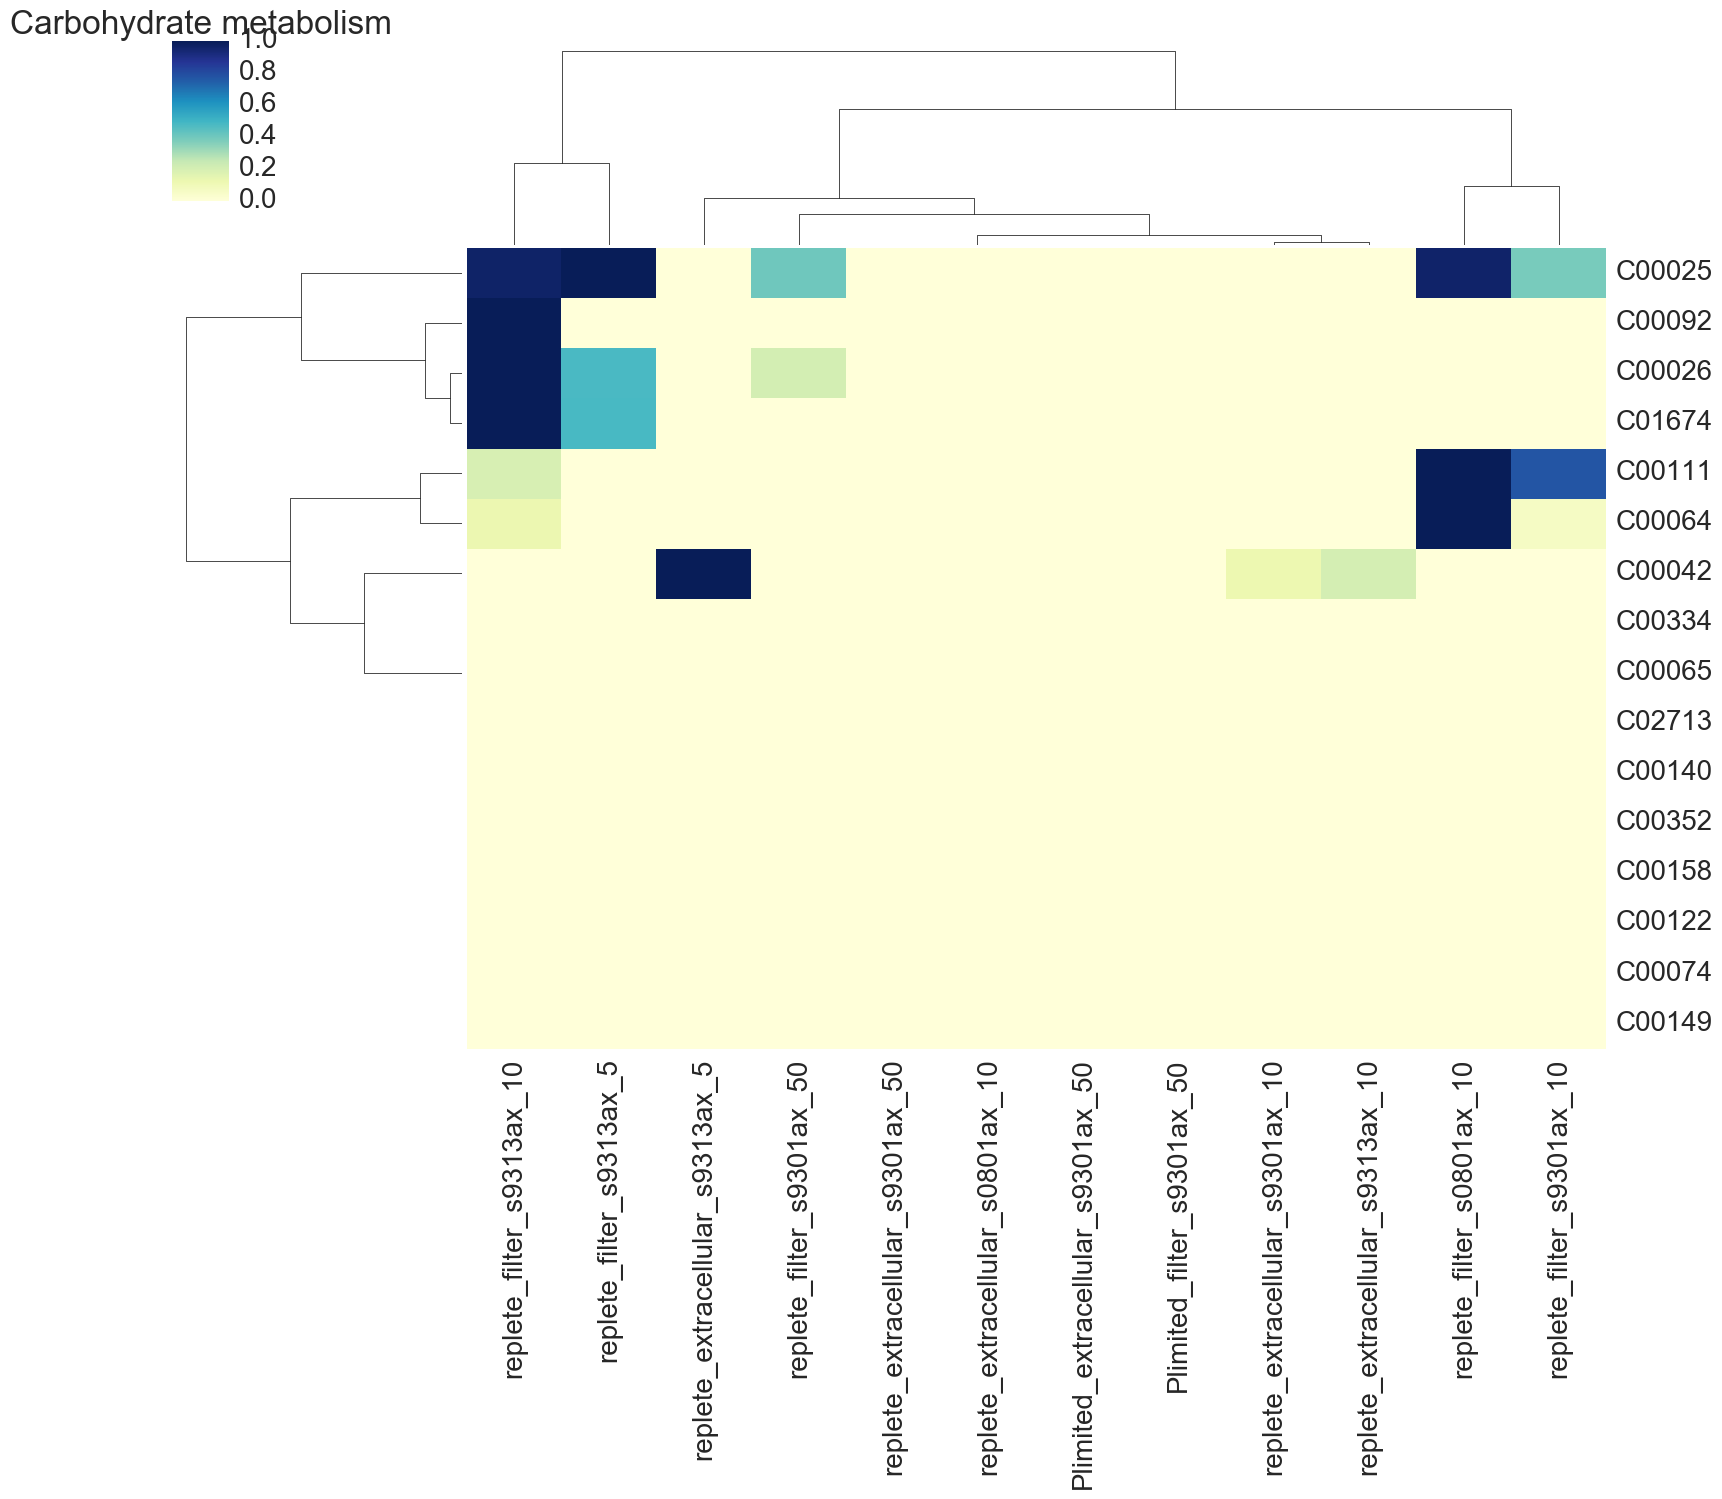

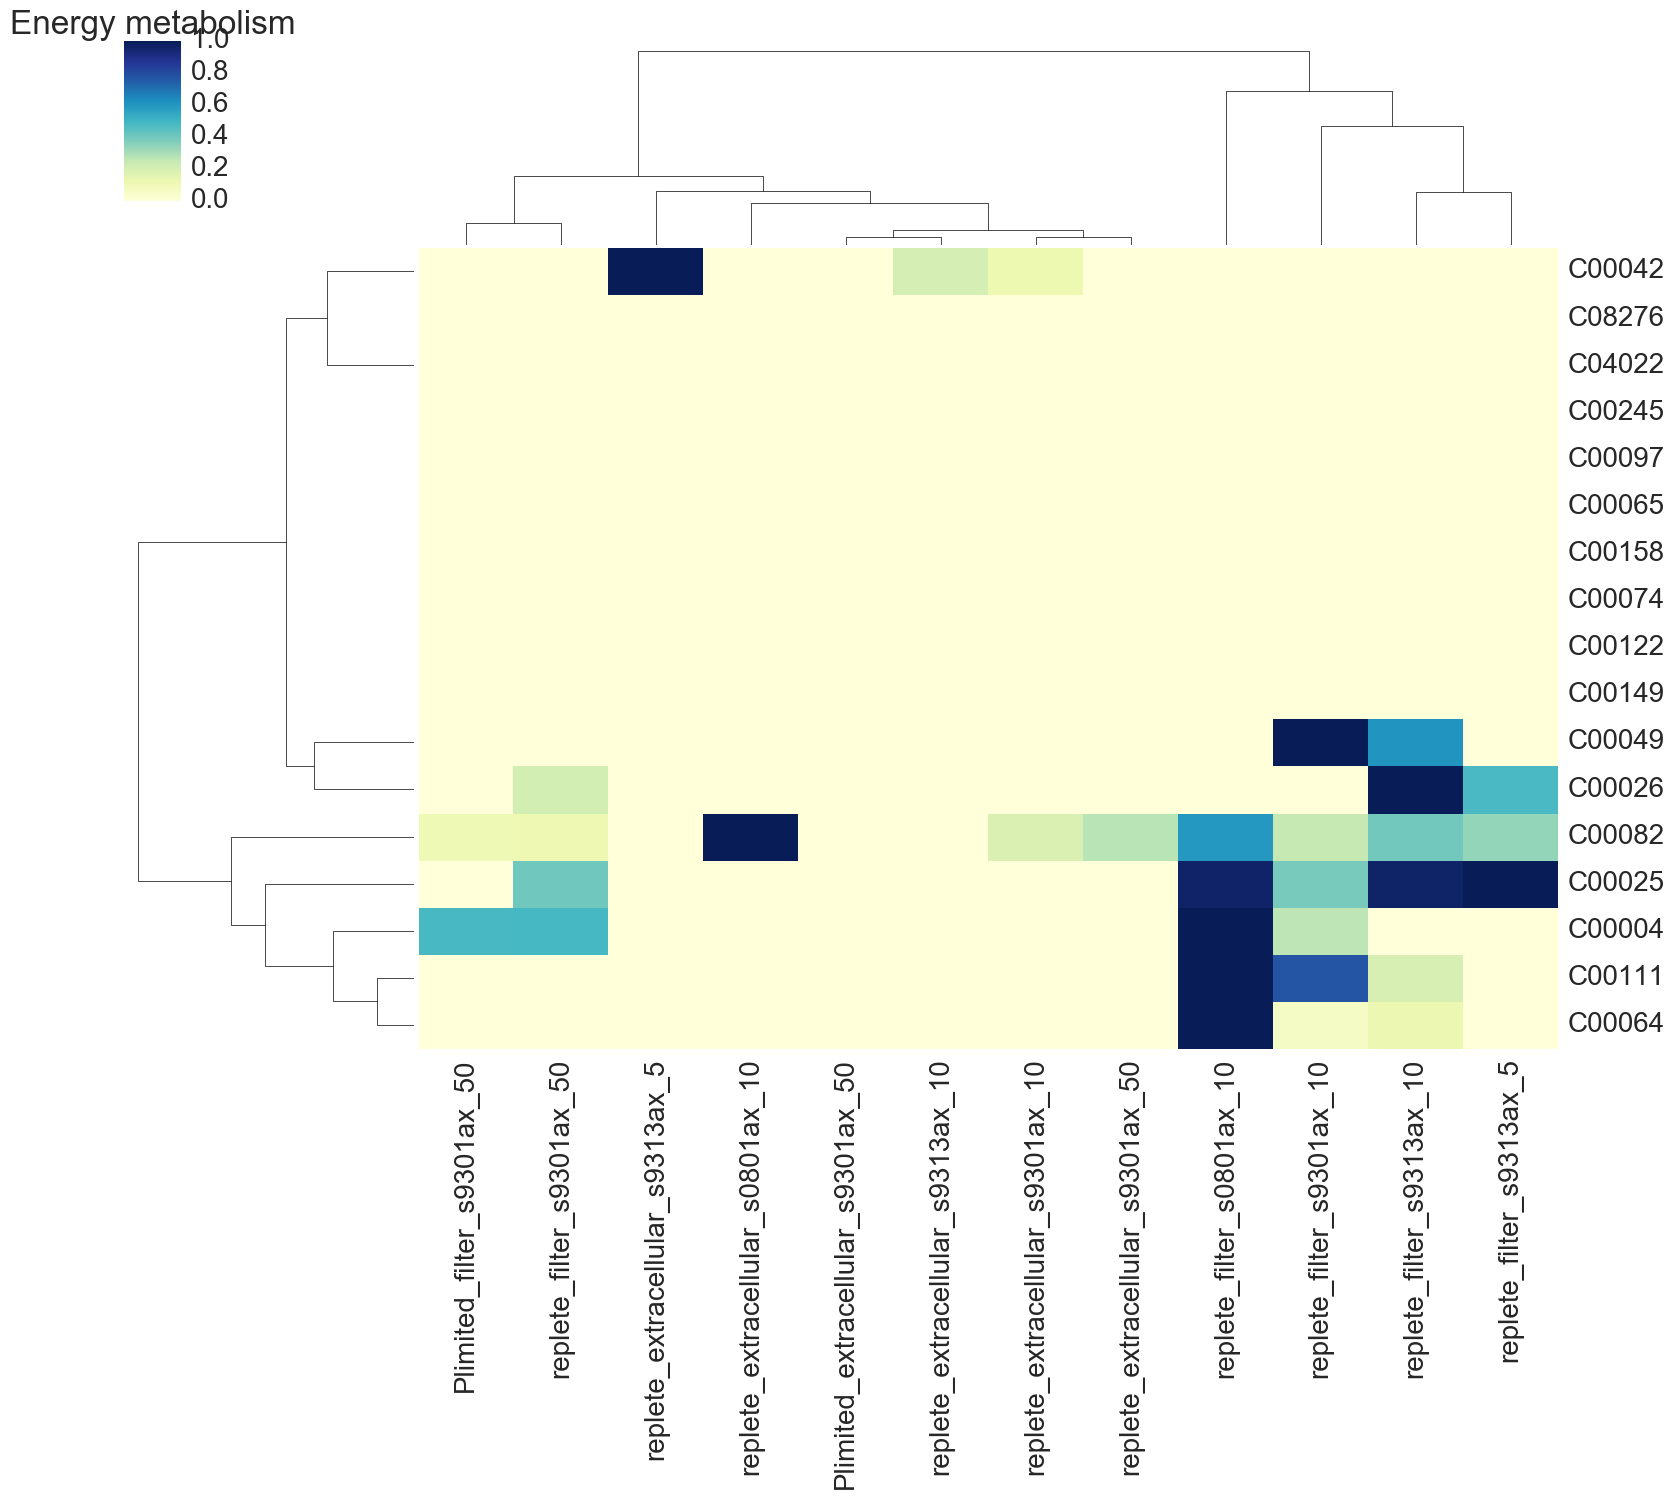

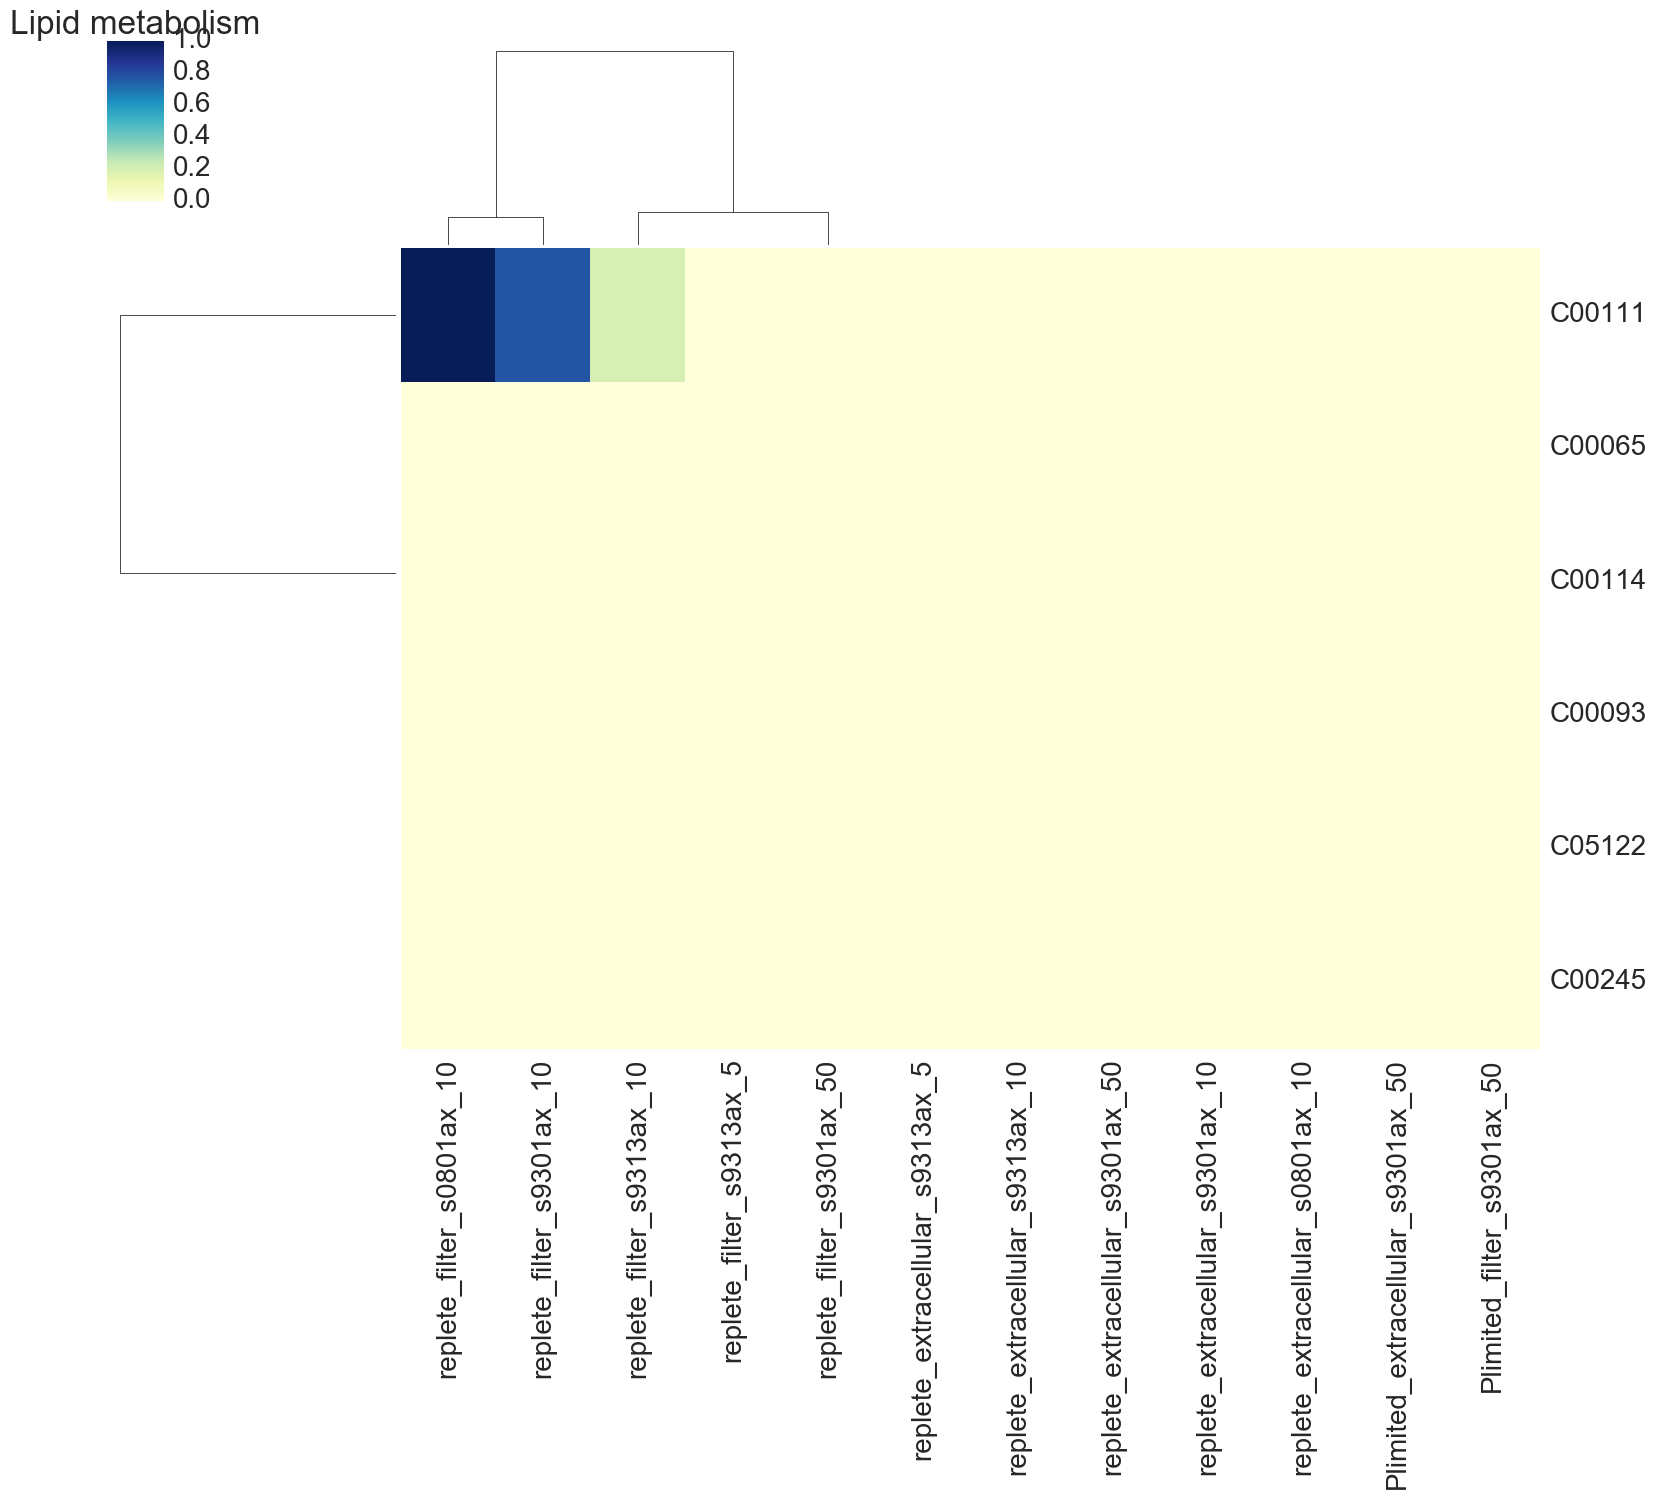

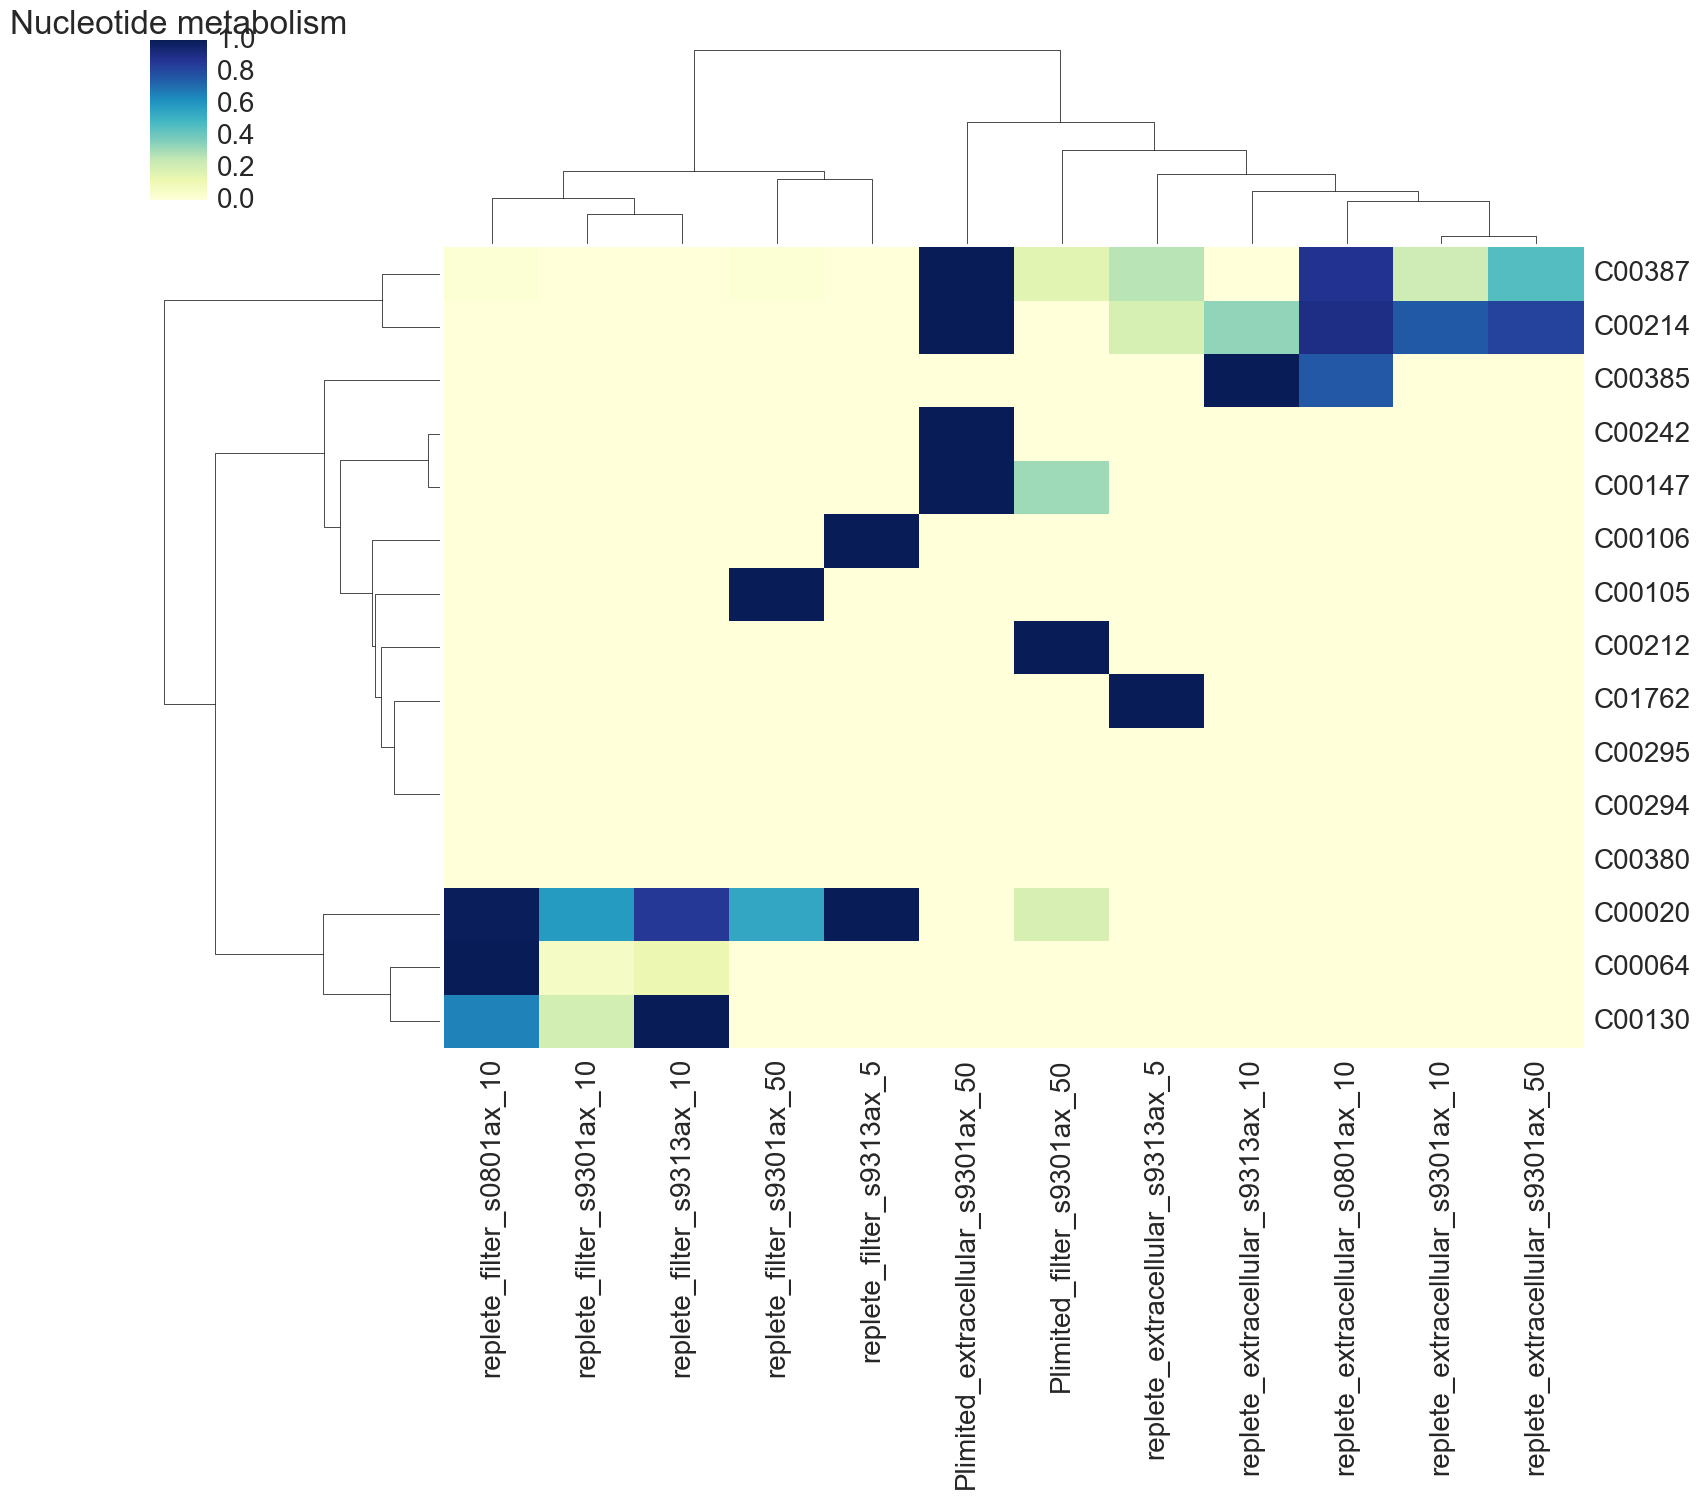

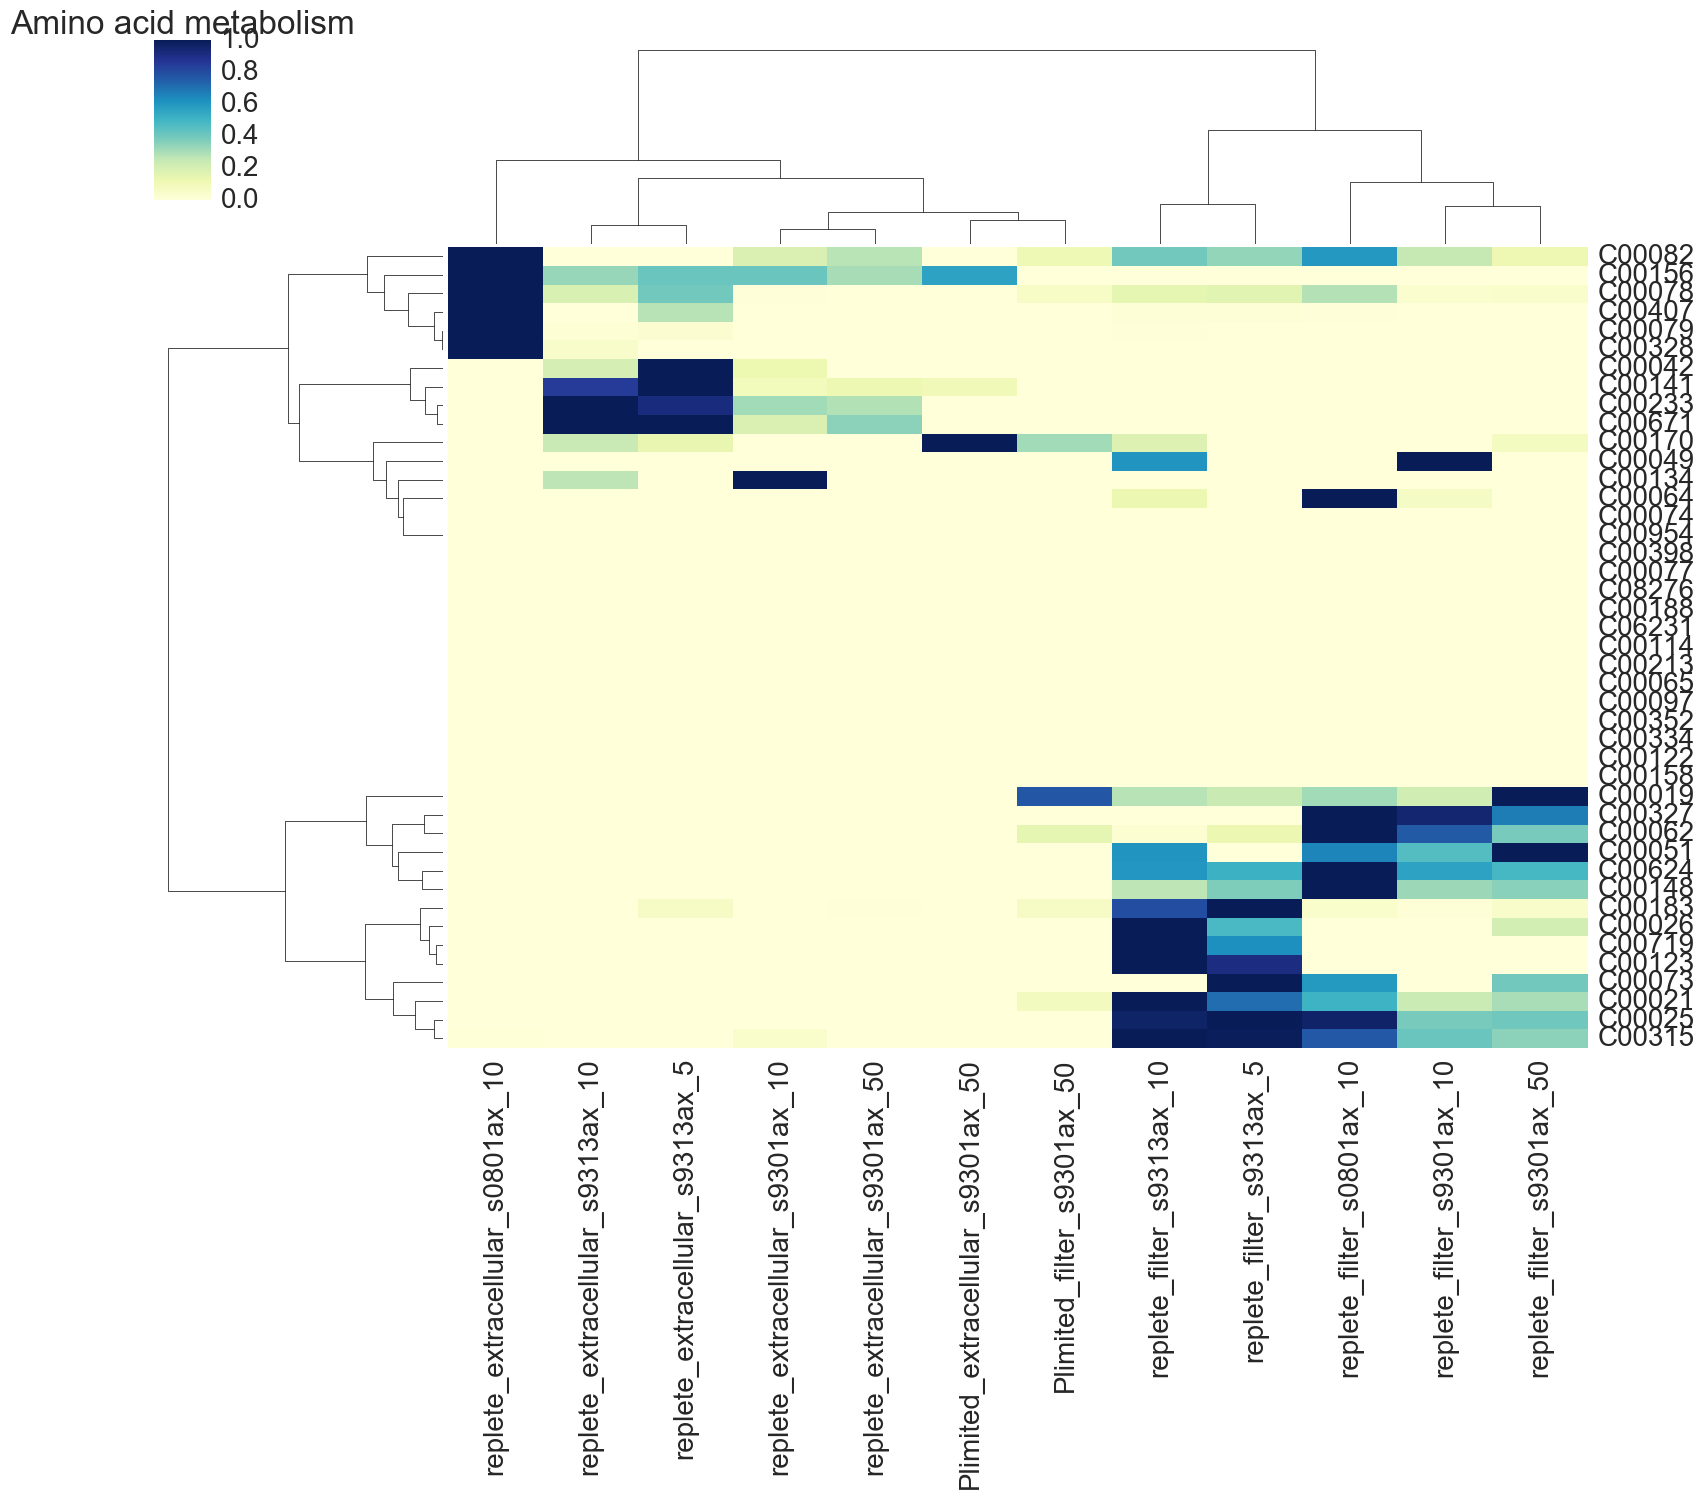

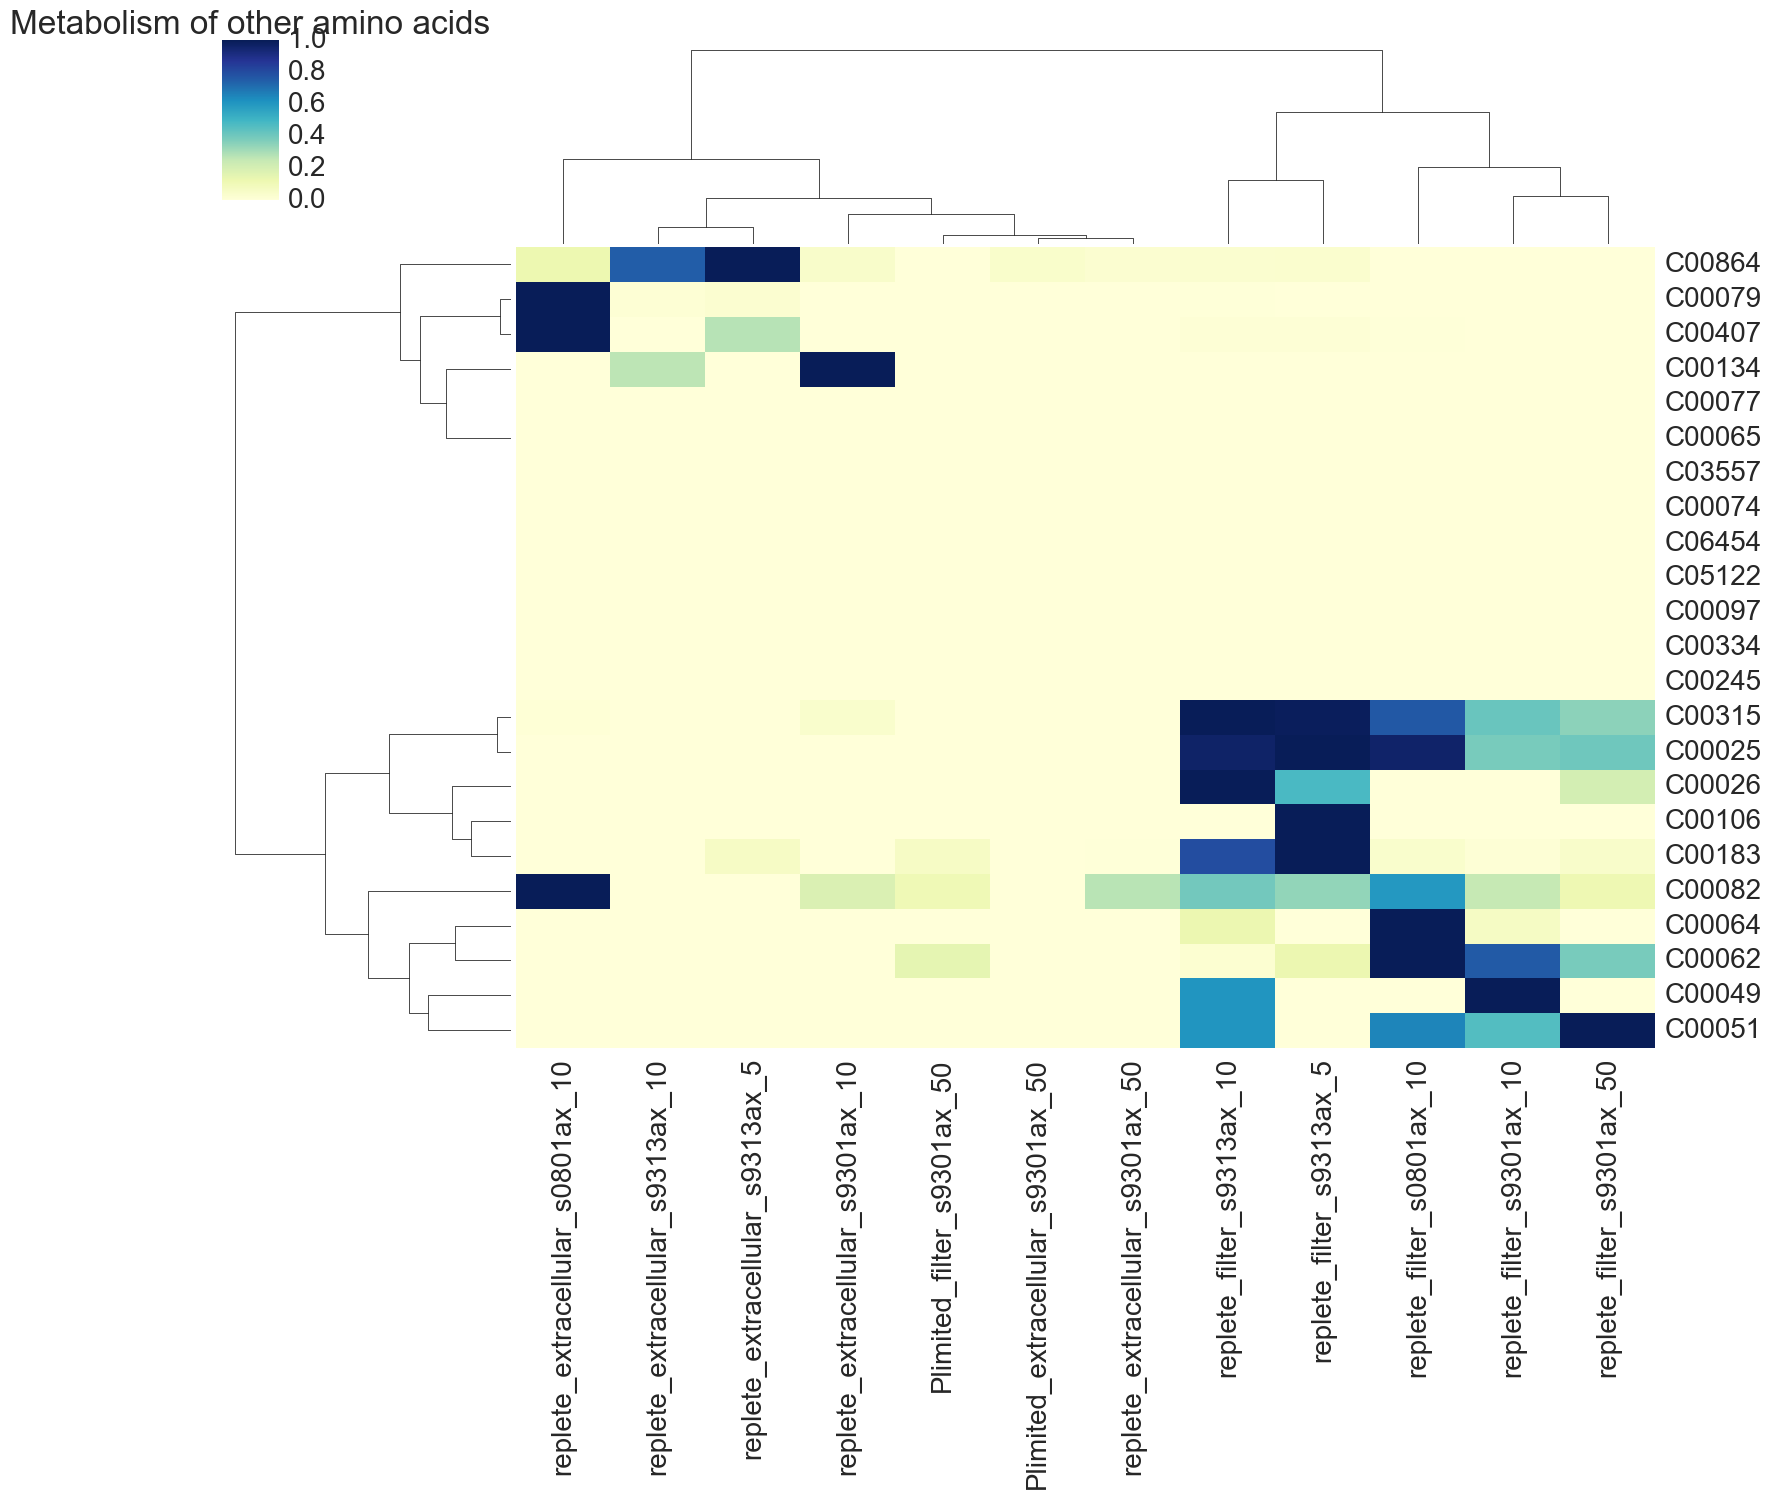

Glycan biosynthesis and metabolism: has no metabolites


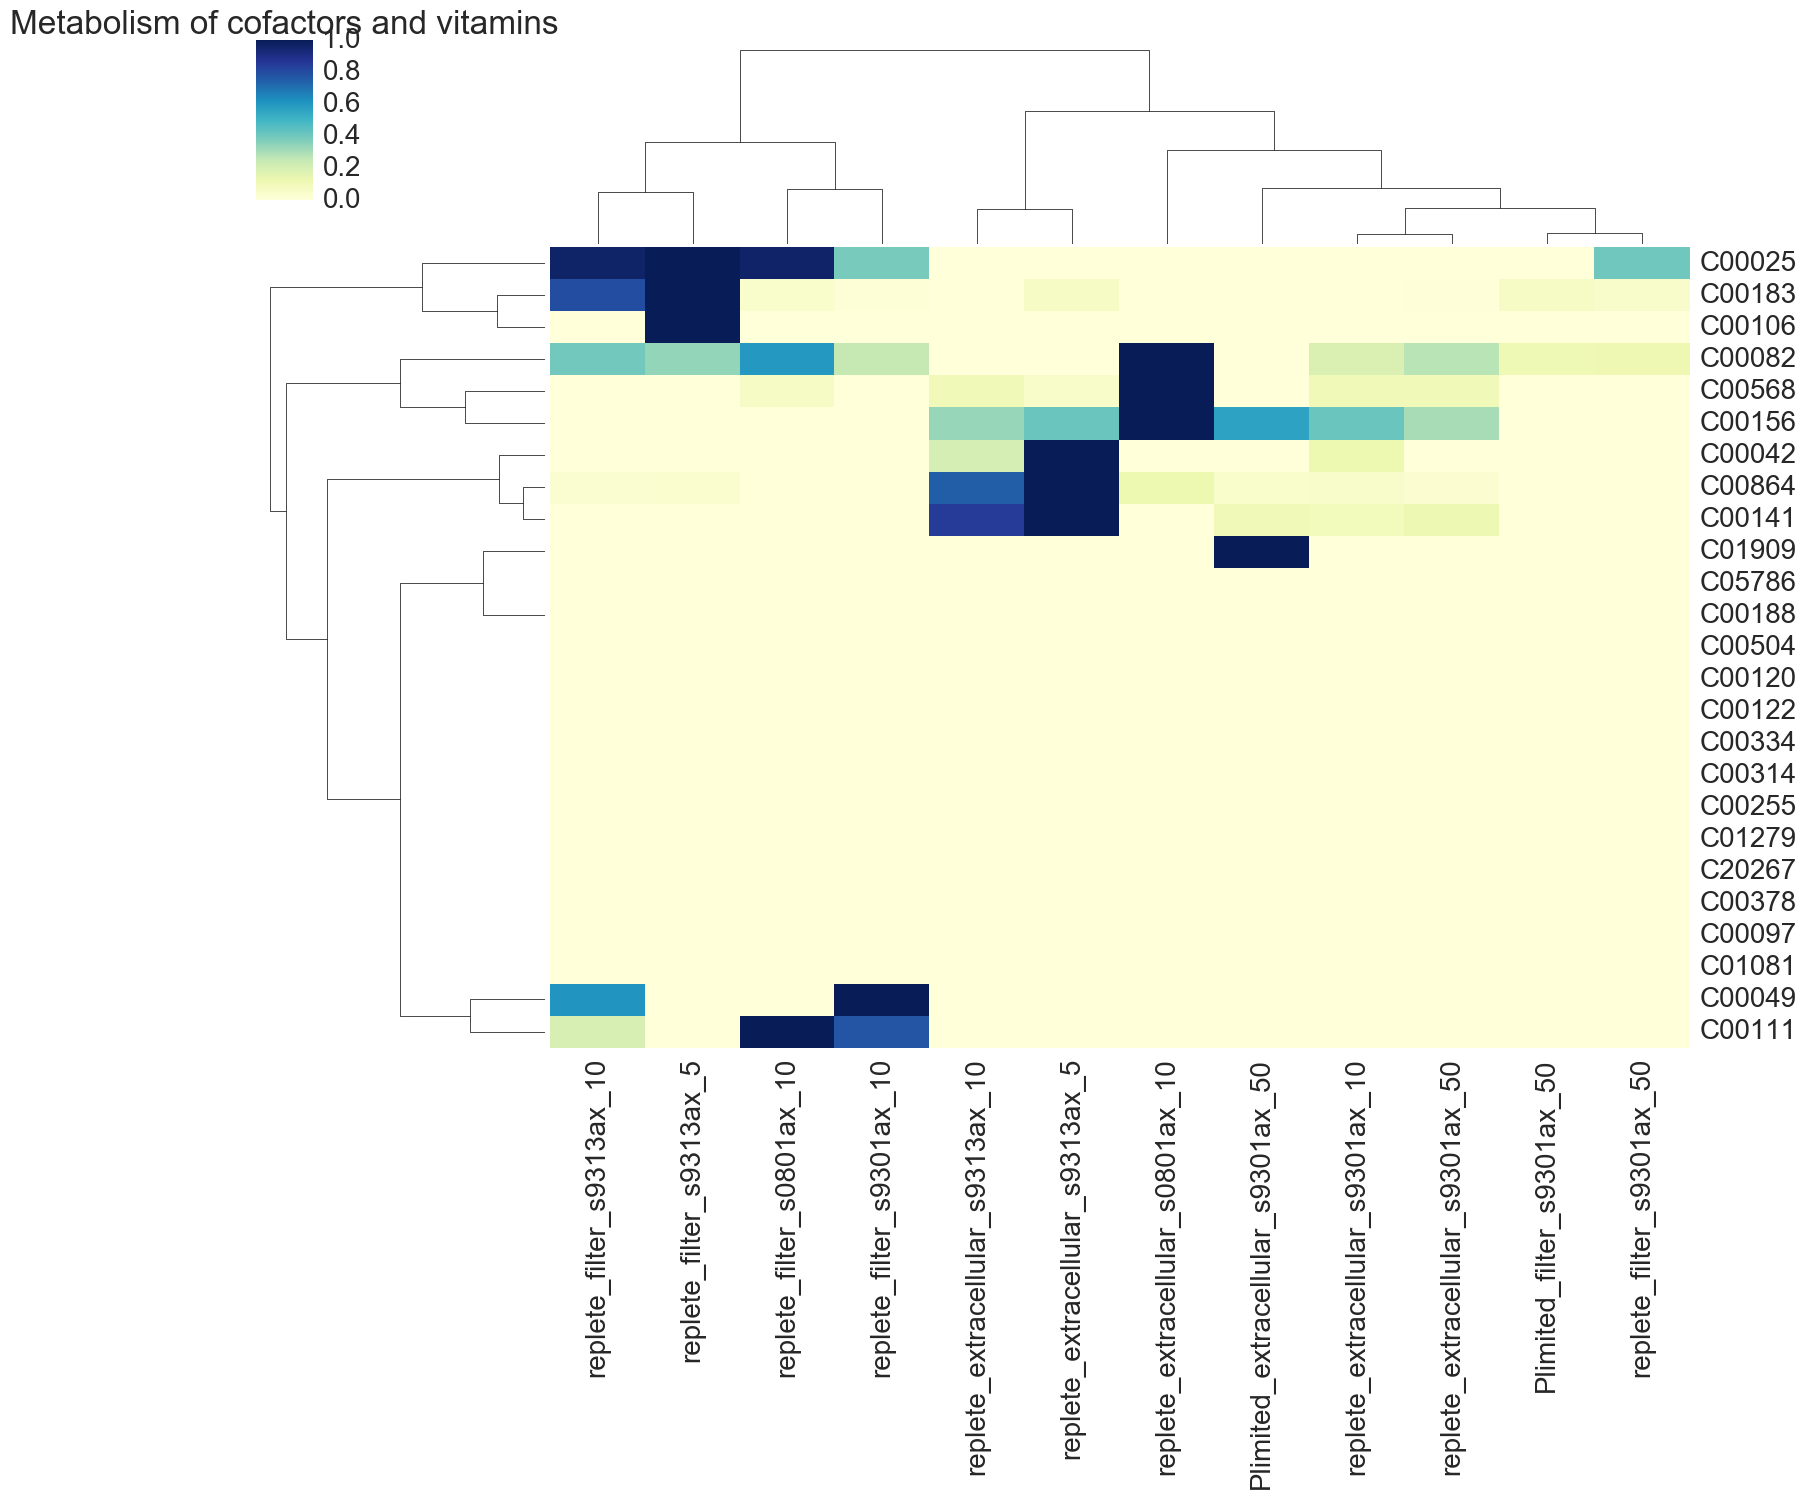

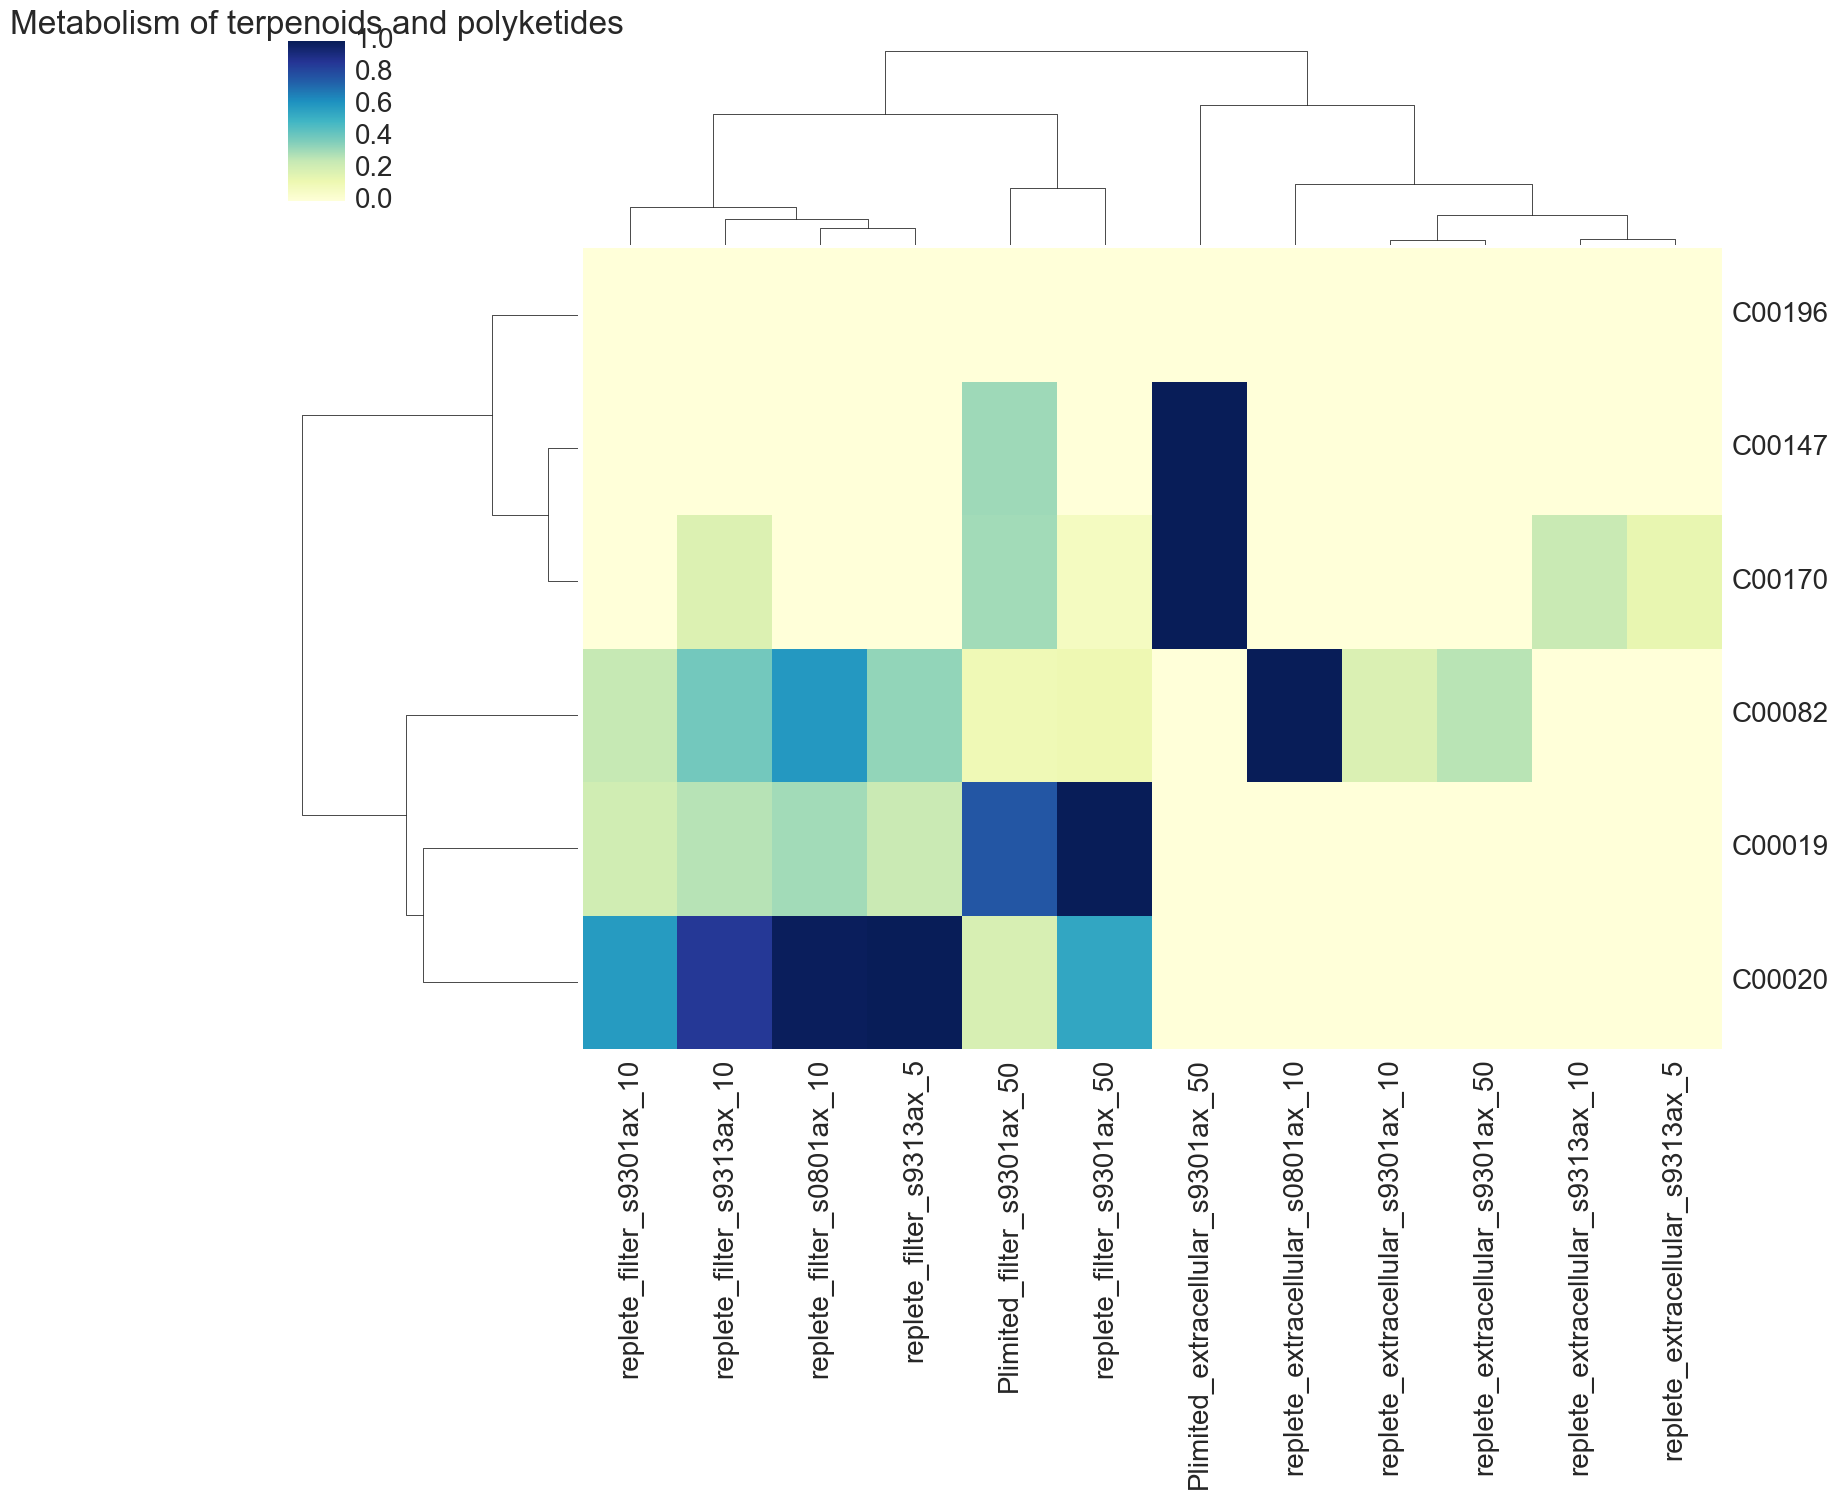

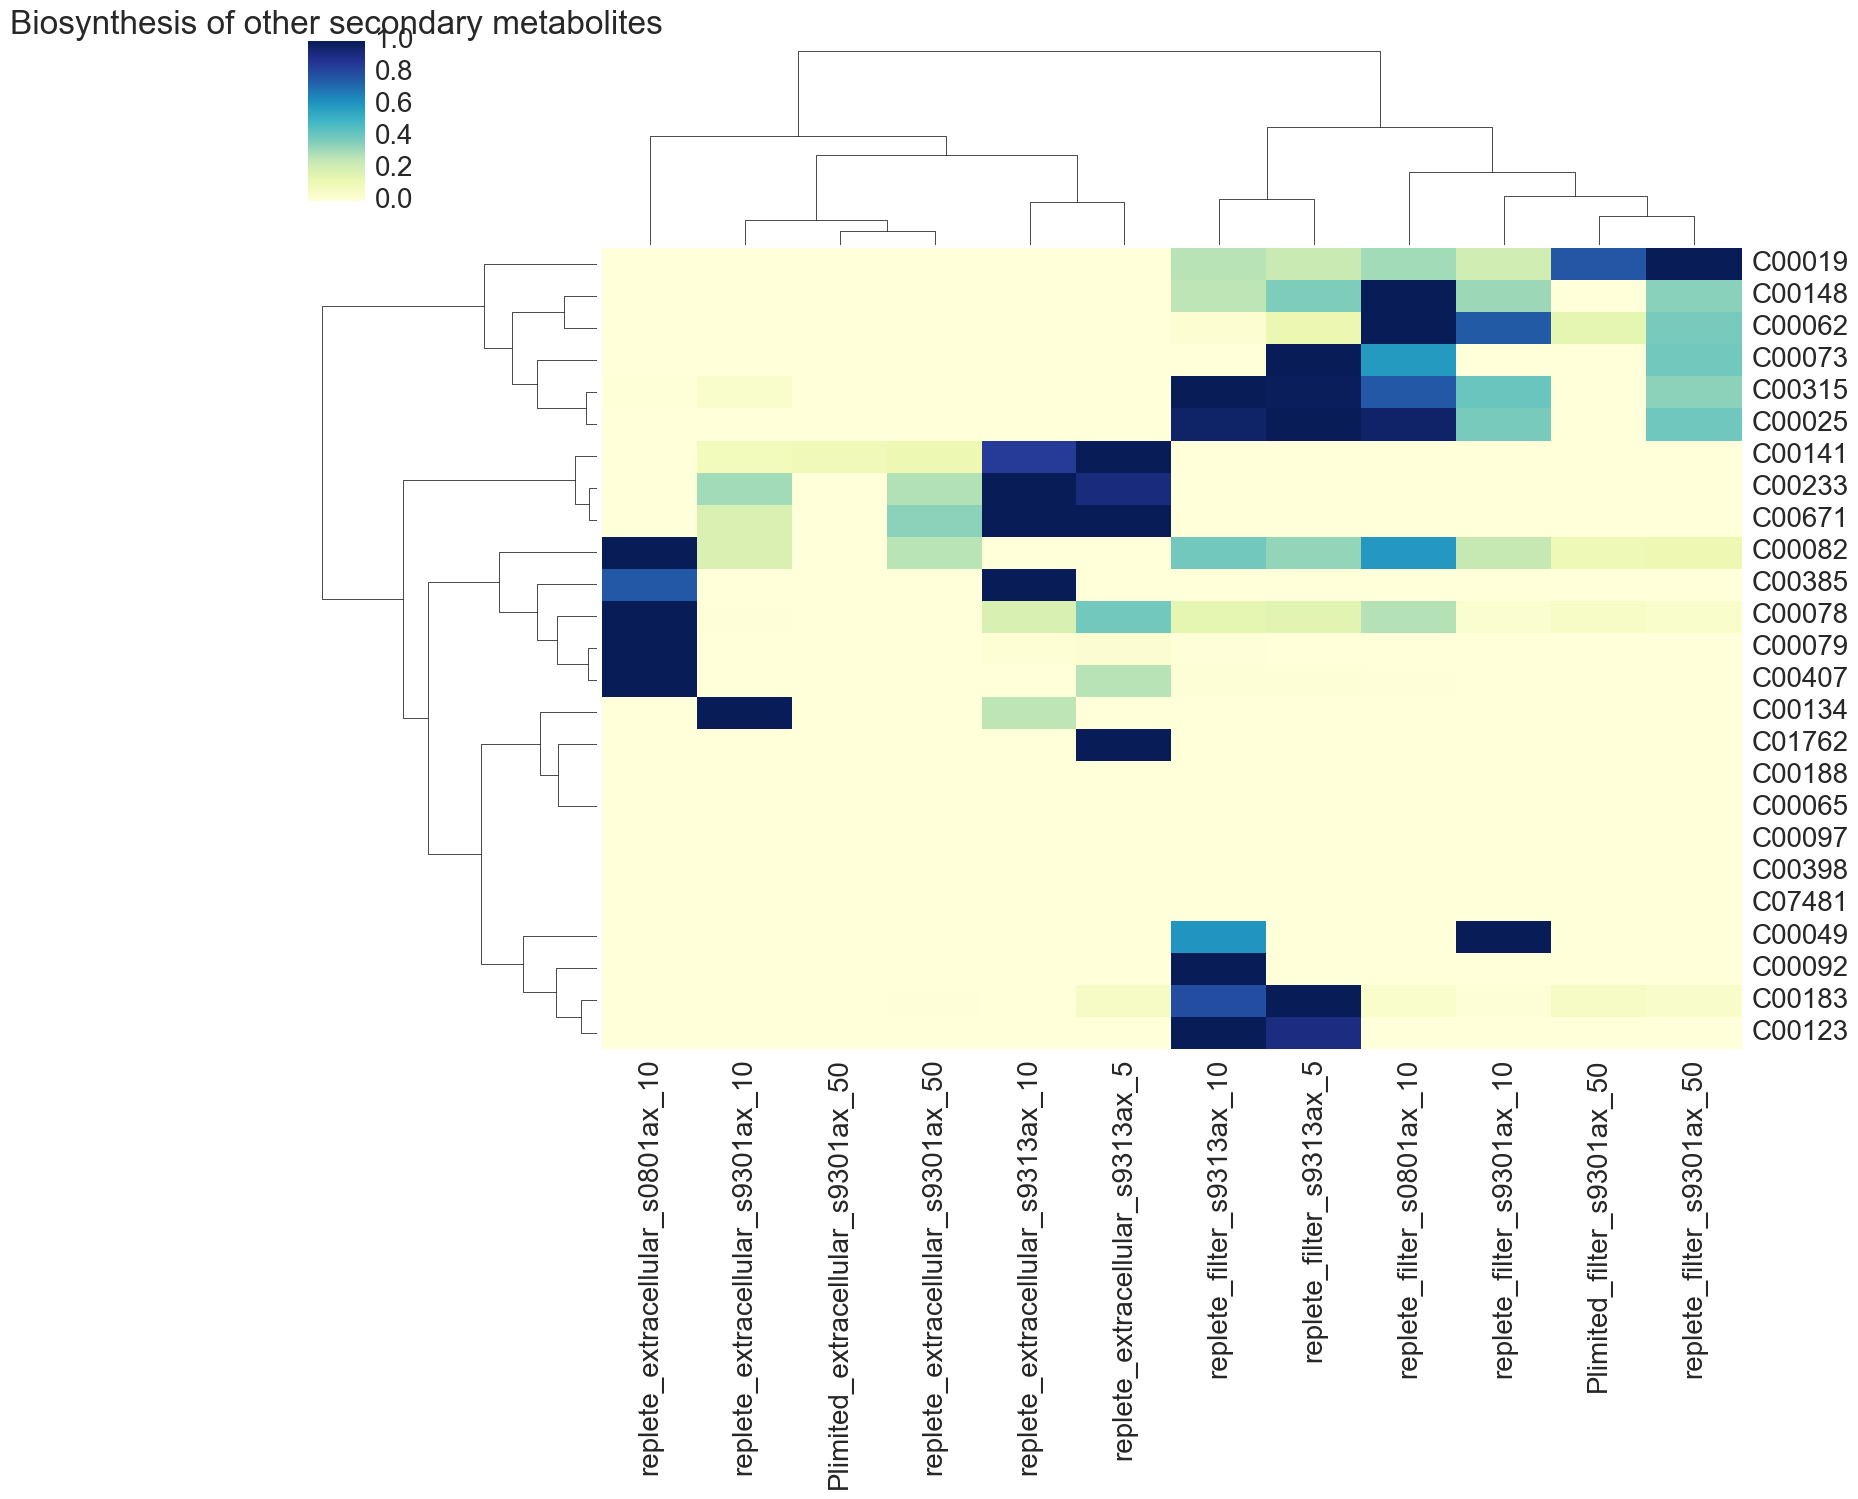

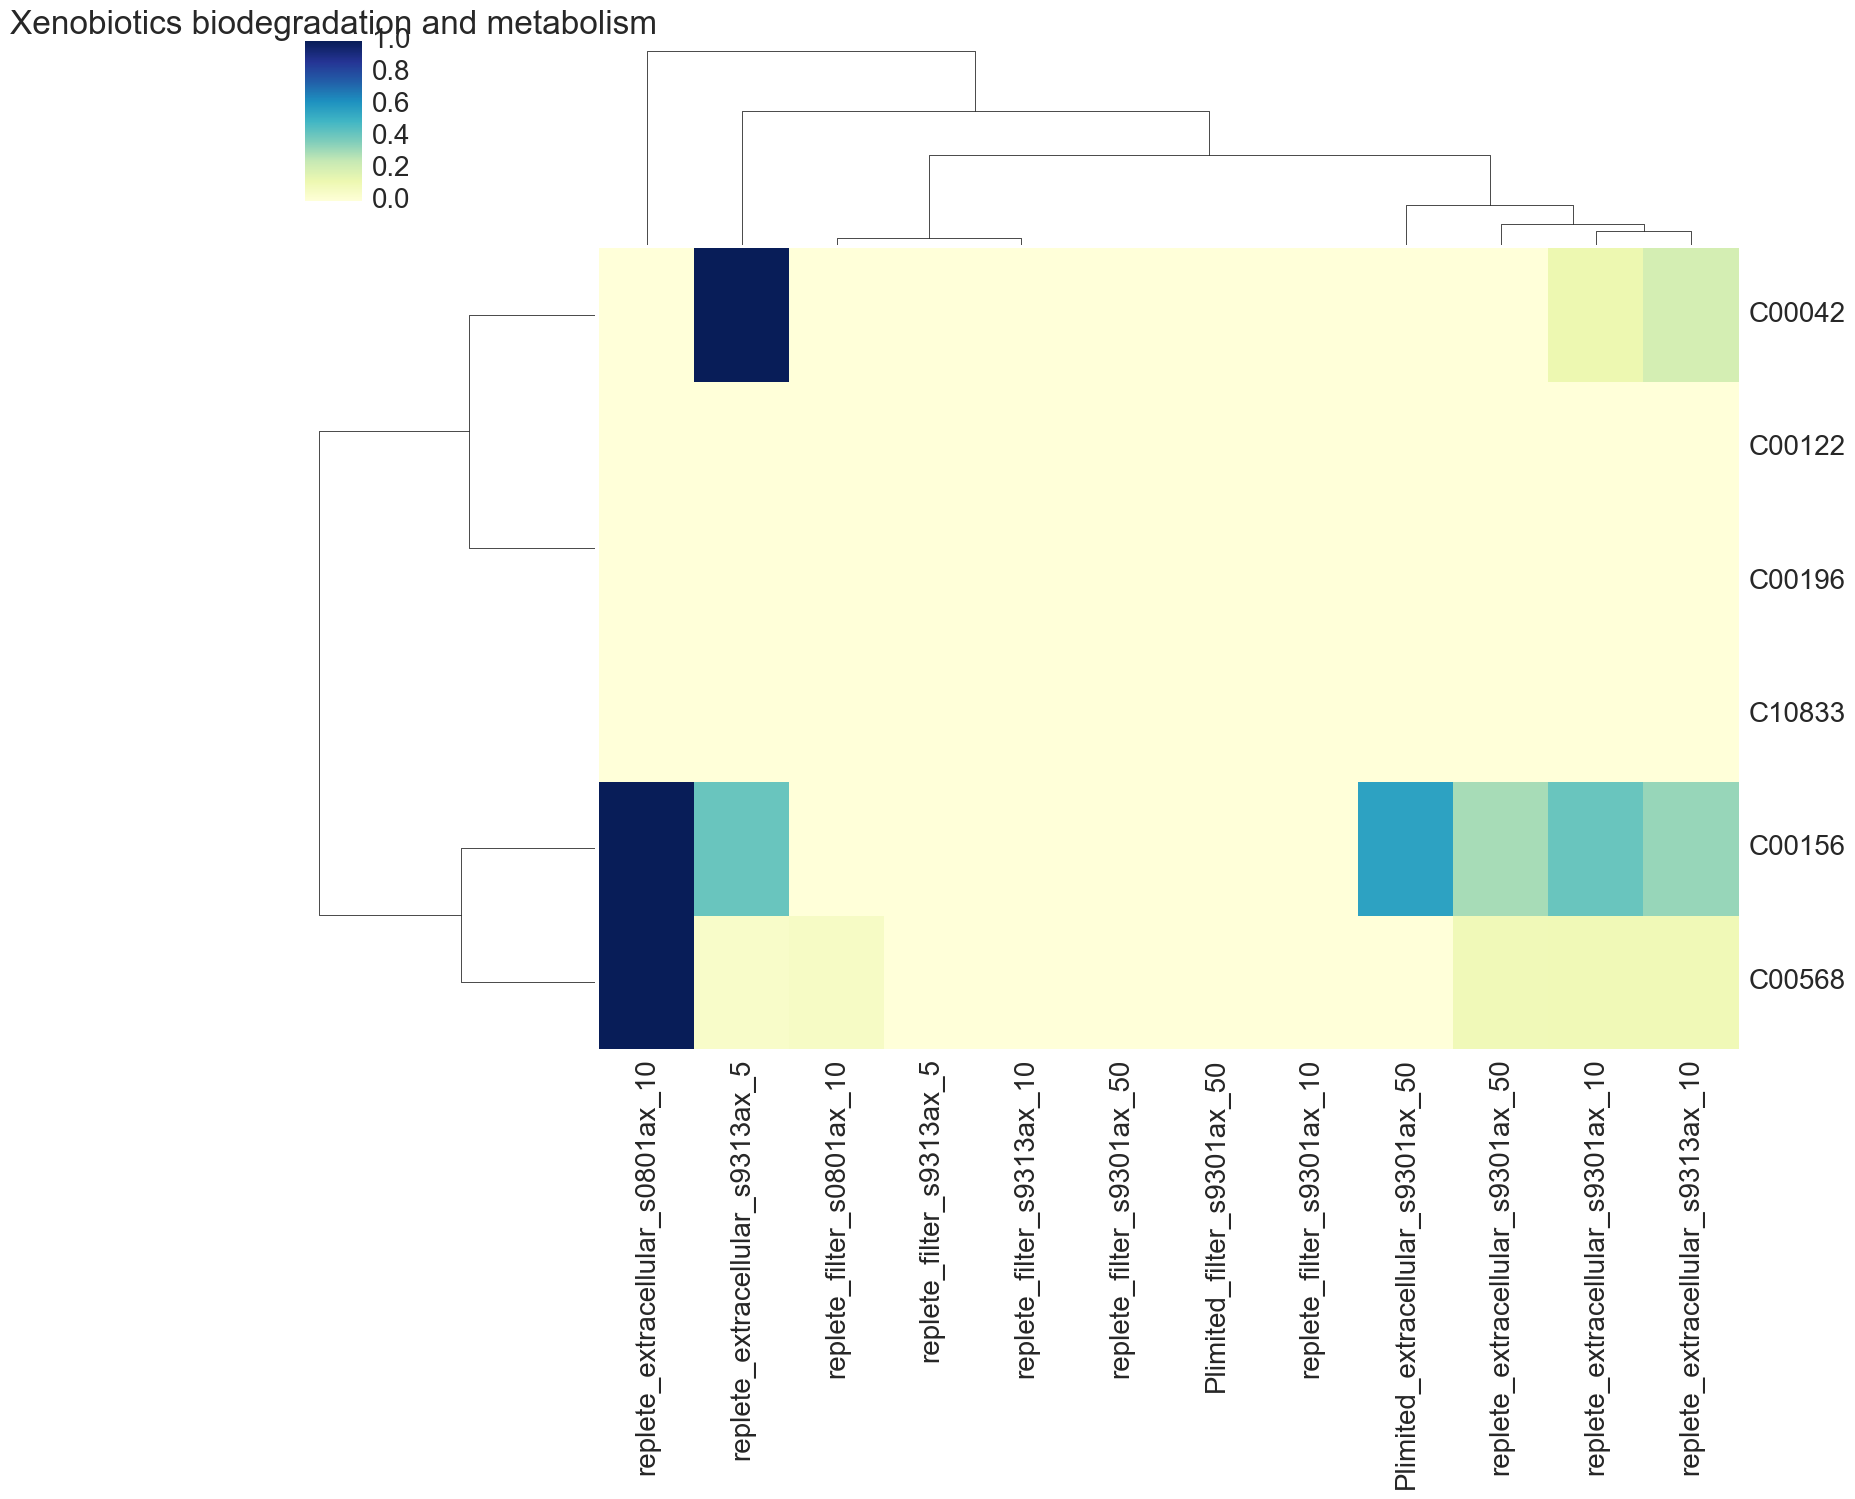

Chemical structure transformation maps: has no metabolites


In [174]:
#plot the data for each type of metabolism map (all strains)
useCO = mtabPruned.index
for oneGroup in unMetabolismGroups:
    #next line will make the color maps for each group: purple = low; green = high
    #these are scaled data, from 01 to 1 
    scaled = True
    plotByGroup.plotGroup_cluster(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain,scaled)

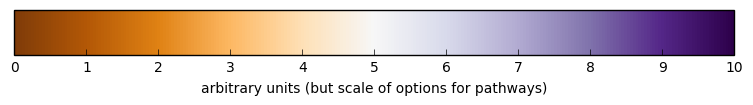

In [18]:
import colorbar_only
#reload(colorbar_only)
#this will be the range of colors in the pathway maps (PDF files) (not green bc genes are green)

In [19]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

Use the information at KEGG to find the theoretical overlap across the strains
----

In [20]:
#use biopython/KEGG module to get the information
pmgPathways = kegg_list('pathway','pmg').read()
pmgTrim = trimPath(pmgPathways)

prmPathways = kegg_list('pathway','prm').read()
prmTrim = trimPath(prmPathways)

pmtPathways = kegg_list('pathway','pmt').read()
pmtTrim = trimPath(pmtPathways)

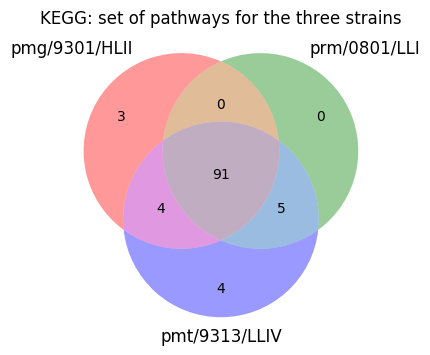

In [21]:
venn3_unweighted(subsets = (set(pmgTrim),set(prmTrim),set(pmtTrim)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of pathways for the three strains')
plt.savefig('Pro_pathways.png')

In [22]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

In [23]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimGenes(geneString):
    export_trimGenes = []
    current_section = None
    for line in geneString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        r = line.find('ko:')
        tp = line[r+3 : r+9]
        export_trimGenes.append(tp)
    return export_trimGenes

In [24]:
#pull the full set of genes for each strain...
pmtGenes = trimGenes(kegg_link("ko","pmt").read())
pmgGenes = trimGenes(kegg_link("ko","pmg").read())
prmGenes = trimGenes(kegg_link("ko","prm").read())

In [25]:
#pull the full set of compounds for each strain...
#have to loop through the genes because the KEGG / REST code will not do this 

In [26]:
#setup the strings to match first
rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190

pmg_countCpd = []
pmg_countGene = []
pmg_countRxn = []
        
for gen in pmgGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmg_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmg_countCpd.append(m2) 
                    pmg_countGene.append(gen)

In [27]:
pmt_countCpd = []
pmt_countGene = []
pmt_countRxn = []

for gen in pmtGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmt_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmt_countCpd.append(m2) 
                    pmt_countGene.append(gen)

In [28]:
prm_countCpd = []
prm_countGene = []
prm_countRxn = []

for gen in prmGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            prm_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    prm_countCpd.append(m2) 
                    prm_countGene.append(gen)

Consider the overlap in compounds among the three strains
---

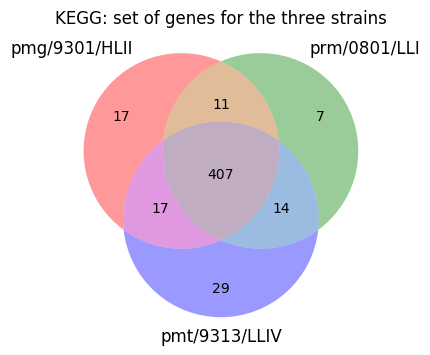

In [29]:
v = venn3_unweighted(subsets = (set(pmg_countGene),set(prm_countGene),set(pmt_countGene)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of genes for the three strains')
#plt.savefig('Pro_genes.png')

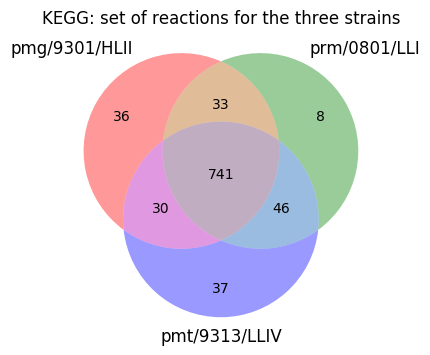

In [30]:
v = venn3_unweighted(subsets = (set(pmg_countRxn),set(prm_countRxn),set(pmt_countRxn)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of reactions for the three strains')
#plt.show() #don't do this...this creates a new figure
#plt.savefig('Pro_reactions.png')

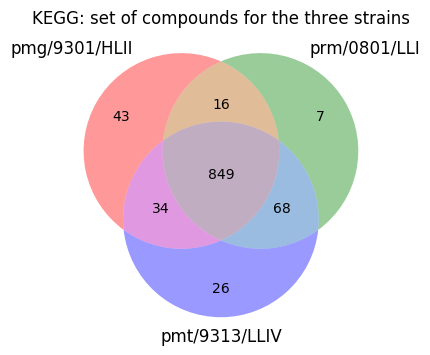

In [31]:
venn3_unweighted(subsets = (set(pmg_countCpd),set(prm_countCpd),set(pmt_countCpd)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of compounds for the three strains')
plt.savefig('Pro_cpds.png')

In [32]:
#what are the differences?

In [33]:
rxnString = set(prm_countRxn) - (set(pmg_countRxn)| set(pmt_countRxn))
#rxnString = set(pmg_countRxn) - (set(prm_countRxn)| set(pmt_countRxn))
#rxnString = set(pmt_countRxn) - (set(prm_countRxn)| set(pmg_countRxn))
#set(pmg_countGene) & set(prm_countGene)- set(pmt_countGene)
rxnString.pop()

'R00956'

In [34]:
kegg_get('R00956').read()

'ENTRY       R00956                      Reaction\nNAME        CTP:alpha-D-glucose-1-phosphate cytidylyltransferase\nDEFINITION  CTP + D-Glucose 1-phosphate <=> Diphosphate + CDP-glucose\nEQUATION    C00063 + C00103 <=> C00013 + C00501\nRCLASS      RC00002  C00103_C00501\nENZYME      2.7.7.33\nPATHWAY     rn00500  Starch and sucrose metabolism\n            rn00520  Amino sugar and nucleotide sugar metabolism\n            rn01100  Metabolic pathways\nORTHOLOGY   K00978  glucose-1-phosphate cytidylyltransferase [EC:2.7.7.33]\n///\n'

In [35]:
cpdString = set(prm_countCpd) - (set(pmg_countCpd)| set(pmt_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C01219	CDP-4-dehydro-6-deoxy-D-glucose

cpd:C00501	CDP-glucose; CDP-D-Glucose

cpd:C00186	(S)-Lactate; L-Lactate; L-Lactic acid

cpd:C01417	Cyanate; Cyanic acid

cpd:C20762	3-O-Phospho-alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol

cpd:C20763	3-O-Methylphospho-alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol

cpd:C20761	alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol



In [36]:
#remember - this is the theoretical overlap based on KEGG
all3 = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        print(kegg_list(item).read())

cpd:C00120	Biotin; D-Biotin; Vitamin H; Coenzyme R

cpd:C00021	S-Adenosyl-L-homocysteine; S-Adenosylhomocysteine

cpd:C00079	L-Phenylalanine; (S)-alpha-Amino-beta-phenylpropionic acid

cpd:C00378	Thiamine; Thiamin; Vitamin B1; Aneurin; Antiberiberi factor

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C02713	N-Acetylmuramate; N-Acetylmuramic acid; N-Acetyl-D-muramoate

cpd:C00864	Pantothenate; Pantothenic acid; (R)-Pantothenate

cpd:C00065	L-Serine; L-2-Amino-3-hydroxypropionic acid; L-3-Hydroxy-alanine; Serine

cpd:C00188	L-Threonine; 2-Amino-3-hydroxybutyric acid

cpd:C00352	D-Glucosamine 6-phosphate; D-Glucosamine phosphate

cpd:C00170	5'-Methylthioadenosine; Methylthioadenosine; S-Methyl-5'-thioadenosine; 5-Methylthioadenosine; 5'-Deoxy-5'-(methylthio)adenosine; Thiomethyladenosine; MTA

cpd:C00624	N-Acetyl-L-glutamate; N-Acetyl-L-glutamic acid

cpd:C00214	Thymidine; Deoxythymidine

cpd:C01081	Thiamin monophosphate; Thiamine monoph

In [37]:
#is a cpd in all three strains? or some lower number? ...only filter data here
cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0','s9301','s0801','s9313'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('filter_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            cpd_inNstrains.loc[oneCpd,st] = 1
    
    a = cpd_inNstrains.loc[oneCpd,strains].sum()

    if a == 3:
        cpd_inNstrains.loc[oneCpd,'in3'] = 1
    elif a == 2:
        cpd_inNstrains.loc[oneCpd,'in2'] = 1
    elif a == 1:
        cpd_inNstrains.loc[oneCpd,'in1'] = 1
    else: #will never have a=0 bc the if not r.empty statement
        cpd_inNstrains.loc[oneCpd,'in0'] = 1
        
sumCount = cpd_inNstrains.sum(axis=0)

In [38]:
r = cpd_inNstrains[cpd_inNstrains.loc[:,'in3'].gt(0)] #in 3...perhaps 'core' mtabs in Pro
for item in r.index:
    print(kegg_list(item).read())

cpd:C00671	(S)-3-Methyl-2-oxopentanoic acid; (S)-3-Methyl-2-oxopentanoate; (3S)-3-Methyl-2-oxopentanoic acid; (3S)-3-Methyl-2-oxopentanoate

cpd:C00233	4-Methyl-2-oxopentanoate; 2-Oxoisocaproate

cpd:C00020	AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00130	IMP; Inosinic acid; Inosine monophosphate; Inosine 5'-monophosphate; Inosine 5'-phosphate; 5'-Inosinate; 5'-Inosinic acid; 5'-Inosine monophosphate; 5'-IMP

cpd:C00051	Glutathione; 5-L-Glutamyl-L-cysteinylglycine; N-(N-gamma-L-Glutamyl-L-cysteinyl)glycine; gamma-L-Glutamyl-L-cysteinyl-glycine; GSH; Reduced glutathione

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphen

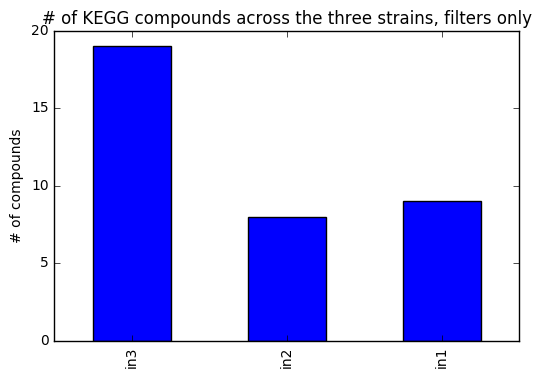

In [39]:
#remember - this is the subset of compounds I expect to find in all three strains...
#also...pre-screened to only be compounds we measured...this figure accounts for 
#anything with a value > 0
fig,axs = plt.subplots(1,1)
sumCount.loc[['in3','in2','in1']].plot(kind = 'bar')
axs.set_title('# of KEGG compounds across the three strains, filters only')
axs.set_ylabel('# of compounds')
fig.savefig('nCompounds.jpg')

Did we see what we expected based on the strain differences?
---

In [40]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s0801']):
        pass
    else:
        #is in the list for strain?
        if item in prm_countCpd:
            pass
        else:
            print(kegg_list(item).read())

In [41]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00719	Betaine; Trimethylaminoacetate; Glycine betaine; N,N,N-Trimethylglycine; Trimethylammonioacetate



In [42]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C00315	Spermidine; N-(3-Aminopropyl)-1,4-butane-diamine



In [43]:
#count up the subsets for plotting (messy)
fi = cpd_inNstrains[cpd_inNstrains.loc[:,'in2']==1]
countSub = fi.sum(axis=0)

fi1 = cpd_inNstrains[cpd_inNstrains.loc[:,'in1']==1]
countSub1 = fi1.sum(axis=0)

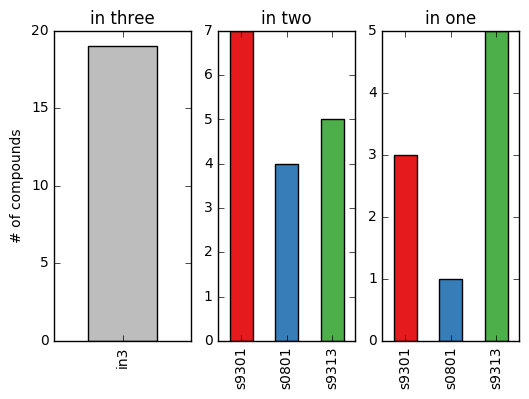

In [53]:
#messy code to get this three panel figure
pStrains = ['s9301','s0801','s9313']
useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors
fig,axs = plt.subplots(1,3)
sumCount.loc[['in3']].plot(kind = 'bar',ax=axs[0],color = '#bdbdbd')
axs[0].set_title('in three')
axs[0].set_ylabel('# of compounds')

countSub.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title('in two')
countSub1.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[2])
axs[2].set_title('in one')
fig.savefig('compoundsSBin3.jpg')

In [54]:
gI = fi1.index

In [55]:
for item in gI:
    if fi1.loc[item,'s9301']==1:
        print(kegg_list(item).read())

cpd:C00147	Adenine; 6-Aminopurine

cpd:C00212	Adenosine

cpd:C00105	UMP; Uridylic acid; Uridine monophosphate; Uridine 5'-monophosphate; 5'Uridylic acid



In [56]:
for item in gI:
    if fi1.loc[item,'s0801']==1:
        print(kegg_list(item).read())

cpd:C00568	4-Aminobenzoate; ABEE; 4-Aminobenzoic acid; p-Aminobenzoate



In [57]:
for item in gI:
    if fi1.loc[item,'s9313']==1:
        print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C00092	D-Glucose 6-phosphate; Glucose 6-phosphate; Robison ester

cpd:C00123	L-Leucine; 2-Amino-4-methylvaleric acid; (2S)-alpha-2-Amino-4-methylvaleric acid; (2S)-alpha-Leucine

cpd:C00864	Pantothenate; Pantothenic acid; (R)-Pantothenate

cpd:C00106	Uracil



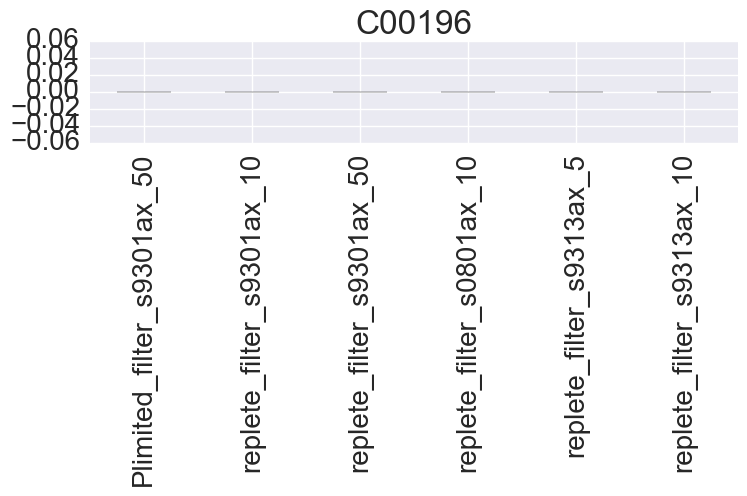

In [165]:
#test one...checking the data
oneCpd = 'C00196'

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = toPlot.plot(kind = 'bar',color = useColors)
sns.set_style("whitegrid", {'axes.grid' : False}) #otherwise seaborn will stick in a gray bkgd
axs.set_title(oneCpd)
plt.tight_layout()
plt.savefig(oneCpd + '.png')

In [60]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimMap(importString):
    export_trimMap = []
    current_section = None
    for line in importString.rstrip().split("\n"):
        r = line.find('map')
        tp = line[r : r+9]
        export_trimMap.append(tp)
    return export_trimMap

In [61]:
#go find all possible pathways for that compound

In [62]:
oneCpd='C01674'
r = kegg_link('pathway',oneCpd).read()
m = trimMap(r)

for item in m:
    print(kegg_list(item).read())

path:map00520	Amino sugar and nucleotide sugar metabolism

path:map01100	Metabolic pathways

path:map02010	ABC transporters

path:map02060	Phosphotransferase system (PTS)



Try extracellur, assume that if in genes, Pro will release it
---

In [63]:
#is a cpd in all three strains? or some lower number? ...extracellular
released_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0','s9301','s0801','s9313'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('extracellular_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            released_inNstrains.loc[oneCpd,st] = 1
    
    a = released_inNstrains.loc[oneCpd,strains].sum()

    if a == 3:
        released_inNstrains.loc[oneCpd,'in3'] = 1
    elif a == 2:
        released_inNstrains.loc[oneCpd,'in2'] = 1
    elif a == 1:
        released_inNstrains.loc[oneCpd,'in1'] = 1
    else: #will never have a=0 bc the if not r.empty statement
        released_inNstrains.loc[oneCpd,'in0'] = 1
        
sumCount_released = released_inNstrains.sum(axis=0)



In [64]:
released_inNstrains.head()

,in3,in2,in1,in0,s9301,s0801,s9313
KEGG,,,,,,,
C00196,NaN,NaN,NaN,1,NaN,NaN,NaN
C19675,NaN,1,NaN,NaN,1,1,NaN
C08276,NaN,NaN,NaN,1,NaN,NaN,NaN
C00141,1,NaN,NaN,NaN,1,1,1
C00671,NaN,1,NaN,NaN,1,NaN,1


In [76]:
r = released_inNstrains[released_inNstrains.loc[:,'in1'].gt(0)] #in 3...perhaps 'core' mtabs in Pro
for item in r.index:
    print(kegg_list(item).read())

cpd:C00147	Adenine; 6-Aminopurine

cpd:C01909	Dethiobiotin; Desthiobiotin

cpd:C00242	Guanine; 2-Amino-6-hydroxypurine

cpd:C01762	Xanthosine



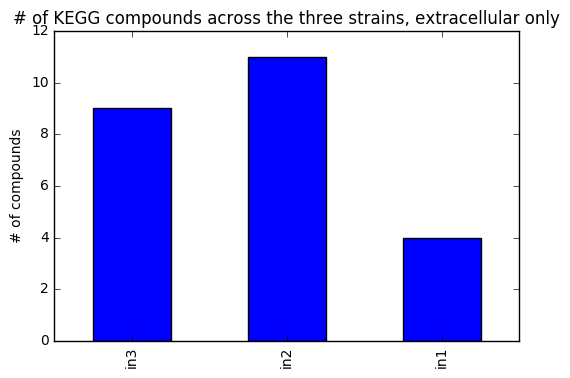

In [66]:
#remember - this is the subset of compounds I expect to find in all three strains...
#also...pre-screened to only be compounds we measured...this figure accounts for 
#anything with a value > 0
fig,axs = plt.subplots(1,1)
sumCount_released.loc[['in3','in2','in1']].plot(kind = 'bar')
axs.set_title('# of KEGG compounds across the three strains, extracellular only')
axs.set_ylabel('# of compounds')
#fig.savefig('nCompounds.jpg')

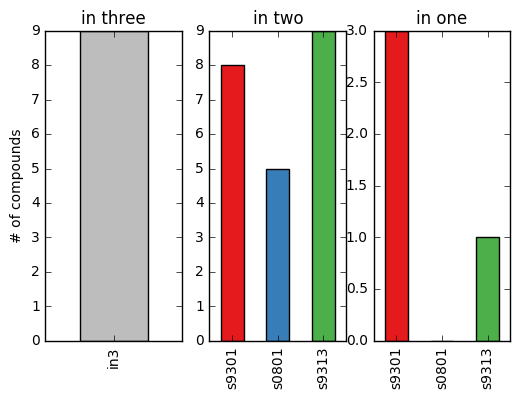

In [69]:
#count up the subsets for plotting (messy); extracellular
efi = released_inNstrains[released_inNstrains.loc[:,'in2']==1]
e_countSub = efi.sum(axis=0)

efi1 = released_inNstrains[released_inNstrains.loc[:,'in1']==1]
e_countSub1 = efi1.sum(axis=0)

useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors

#messy code to get here
fig,axs = plt.subplots(1,3)
sumCount_released.loc[['in3']].plot(kind = 'bar',ax=axs[0],color = '#bdbdbd')
axs[0].set_title('in three')
axs[0].set_ylabel('# of compounds')

e_countSub.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title('in two')
e_countSub1.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[2])
axs[2].set_title('in one')
fig.savefig('compoundsSBin3_extracellular.jpg')



In [70]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s0801']):
        pass
    else:
        #is in the list for strain?
        if item in prm_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [71]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate



In [72]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [149]:
oneCpd='C00954'
r = kegg_link('pathway',oneCpd).read()
m = trimMap(r)

for item in m:
    print(kegg_list(item).read())

path:map00380	Tryptophan metabolism

path:map01070	Biosynthesis of plant hormones

path:map01100	Metabolic pathways

path:map04075	Plant hormone signal transduction



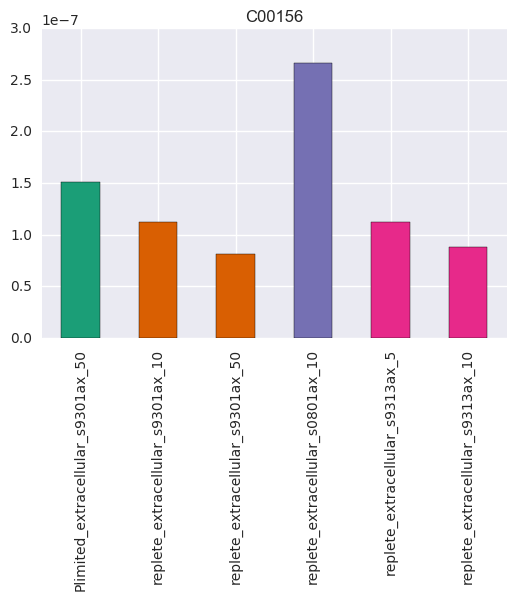

In [110]:
#test one...checking the data
oneCpd = 'C00156'

df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = toPlot.plot(kind = 'bar',color = useColors)
axs.set_title(oneCpd)
if False: #plot?
    plt.tight_layout()
    plt.savefig(oneCpd + '.png')

In [ ]:
import dill                            #pip install dill --user
filename= 'globalsave.pkl'
dill.dump_session(filename)

In [ ]:
import dill
# and to load the session again:
dill.load_session('globalsave.pkl')

In [ ]:
#leave debris below here for now, notebook will stop at the 'raise' 
#command in the next cell to keep me from running cells 
#of code that are not meant to be connected

In [ ]:
raise

In [173]:
#import plotByGroup
reload(plotByGroup)

<module 'plotByGroup' from 'C:\\Users\\krista\\Documents\\GitHub\\Pro_mtabs\\plotByGroup.py'>

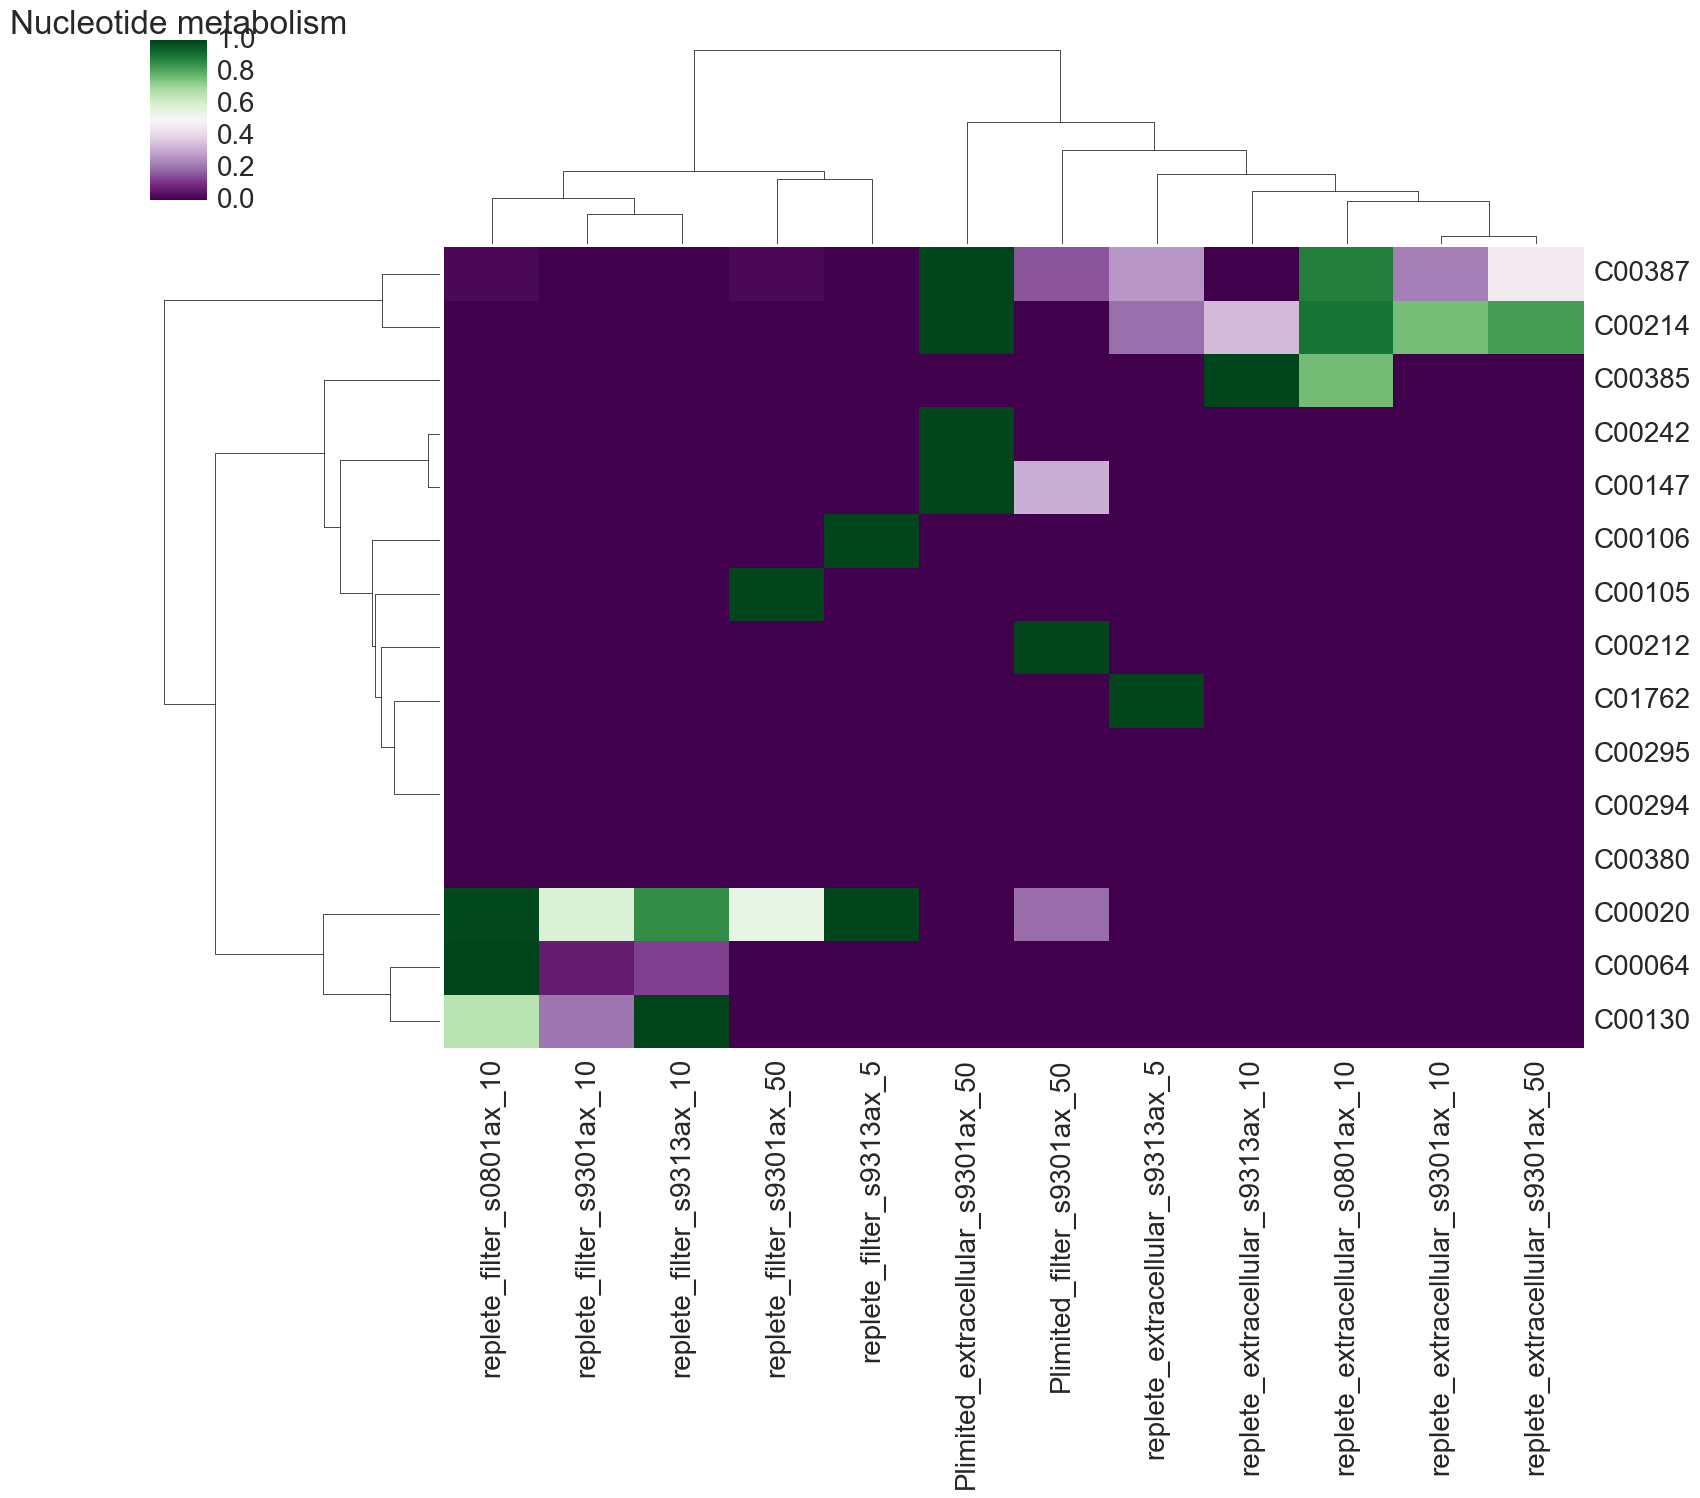

In [141]:
#import plotByGroup
reload(plotByGroup)

oneGroup = 'Nucleotide metabolism'
#plot the pathway maps for one strain and one set of data
oneStrain = 'pmg'
useCO = mtabPruned.index
plotByGroup.plotGroup_cluster(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain,True)

In [ ]:
kegg_link('reaction','C00315').read()
kegg_link('pathway','C00315').read()
kegg_list('map00330').read()
kegg_link('compound','map00260').read()

In [171]:
oneGroup = 'Nucleotide metabolism'
shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
onePath = shortList.loc[:,'map']
onePath_ann = []

for item in onePath:
    onePath_ann.append('ko' + item) #not strain for now

gatherGroup = pd.DataFrame()
for one in onePath_ann:
    #print(one)
    #not all pathways annotated in Prochlorococcus
    setKeep = 1
    try:
        kegg_get(one).read()
    except:
        #use the ko map if there is nothing species specific
        usePathway = 'ko' + one[3:8]
        setKeep = 0
        try:
            kegg_get(usePathway).read()
        except:
            pass

    if setKeep:
        usePathway = one

    try:
        mCpds = set(getCfrom_ko(usePathway))
    except:
        #no ko pathway either
        break

    ProData= set(useCO)
    handh = mCpds.intersection(ProData)
    for cpd in handh:
        #print(cpd)
        #pdb.set_trace()
        tm = mtabPruned.loc[cpd,:]
        if (cpd in gatherGroup.index): 
            pass
        else: #only add the mtab if it is new...can have mtabs in multiple pathways
            gatherGroup = gatherGroup.append(tm)

scaled = preprocessing.minmax_scale(gatherGroup,feature_range=(0,1),axis = 1,copy=True)
scaledDF = pd.DataFrame(scaled,columns = gatherGroup.columns,index = gatherGroup.index) #get row/column labels back

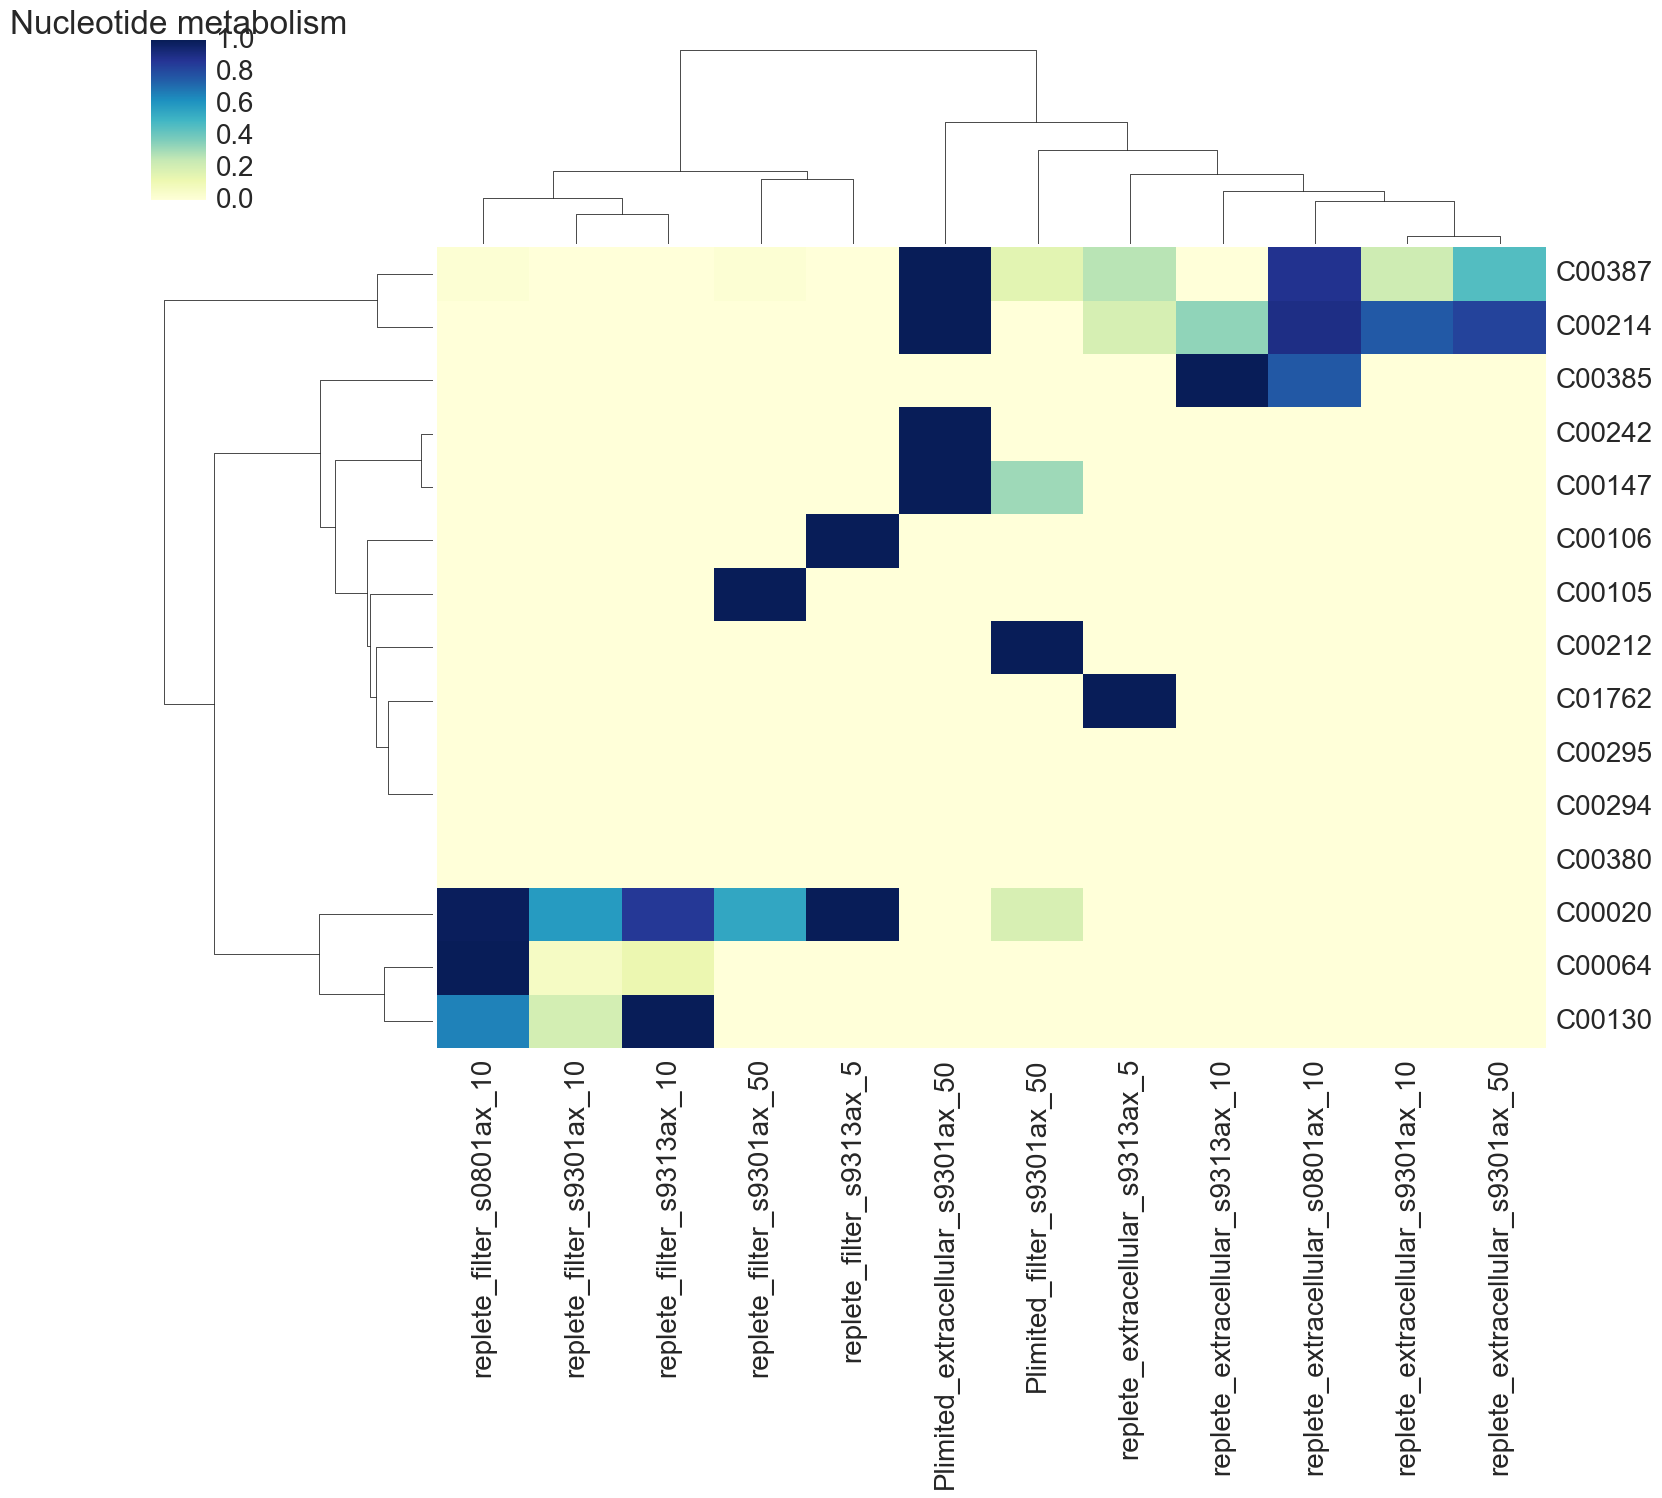

In [172]:
sns.set(font_scale = 2)
g = sns.clustermap(scaledDF,cmap = 'YlGnBu',method = 'ward',metric = 'cityblock')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.title(oneGroup)
fig = plt.gcf()
fig.set_size_inches(18,13)
plt.show() #this will suppress all the rows of 'None'

In [ ]:
filter_cols = [col for col in mtabPruned if 'filter' in col]
#works, but I still need to wrap my head around the list comprehension

In [ ]:
#kegg_get(oneMap).read()
genes = getKfrom_ko(oneMap)
compounds = getCfrom_ko(oneMap)

setG = set(genes)
setC = set(compounds)
setT = set(useCO)
intCompounds = setC.intersection(setT)

useColors = pal.colorbrewer.diverging.PuOr_4.hex_colors
#useColors = pal.colorbrewer.diverging.RdYlBu_11.hex_colors

#set the color of the mtab based on its value, only scale the values from this particular pathway
useCOsubset = CO_values.loc[intCompounds]
cmin = useCOsubset.min() #find min and max...ignore NaN and inf for the moment
cmax = useCOsubset.replace([np.inf],np.nan).dropna(how = 'all').max()

size = 20 #increase the size of the compounds in the plots

pathway = KGML_parser.read(kegg_get(oneMap, "kgml")) #no choice in gene color: green

In [ ]:
        dummy = useCOsubset.copy(deep = True)
        dummy.replace([np.inf],np.nan,inplace = True)
        for idx,item in enumerate(useCOsubset):
            if np.isnan(item):
                useCOsubset.iloc[idx] = 0
            elif np.isinf(item):
                useCOsubset.iloc[idx] = 10*cmax #make inf 10x the biggest value

        #now, find cmax again...use that downstream
        cmax = useCOsubset.replace([np.inf],np.nan).dropna(how = 'all').max()

        #use histogram to make the bins (complete hack)
        a,bin_edges = np.histogram(useCOsubset,bins = len(useColors)-3,range = (cmin,cmax))
        #now...put zero at beginning and inf at end
        #BUT - can actually have cases with values for all metabolites (novel concept)
        try:
            nz = useCOsubset.value_counts()[0] #count the number of zeros
            a = np.insert(a,0,nz)
            bin_edges = np.insert(bin_edges,0,0)
        except:
            pass
            
        try:
            nm = useCOsubset.value_counts()[cmax]
            a = np.append(a,nm)
            bin_edges = np.append(bin_edges,cmax)
        except:
            pass

        #then find the index for each number...this will be the index into useColors
        useIdx = np.digitize(useCOsubset,bin_edges)
        color_df = pd.DataFrame({'mtab': useCOsubset,'idx':useIdx})

In [ ]:
# Change the colors of compounds
for element in pathway.compounds:
    for graphic in element.graphics:
        tc = element.name[4:10] #skip over the 'cpd:'
        if (tc in intCompounds):
            #in the pathway, set the color
            tempColor = useCOsubset.loc[tc]
            graphic.bgcolor = useColors[int(tempColor)] 
            graphic.width = size
            graphic.height = size

canvas = KGMLCanvas(oneMap, import_imagemap=True)
pdfName = 'mapWithColors_' + str(oneMap) + '.pdf'
canvas.draw('testingFolder' + '/' + pdfName)
pdfName = None #empty it in case that is where I am having issues       

In [ ]:
#is this cpd in all three strains? or some lower number...
cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    tMarker = pd.DataFrame(index = ['temp'],columns = ['s9301','s0801','s9313'])
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('filter_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            tMarker.loc['temp',st] = 1

    a = tMarker.sum(axis=1)

    #cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0'])
    #a.loc['temp']
    if a.loc['temp'] == 3:
        cpd_inNstrains.loc[oneCpd,'in3'] = 1
    elif a.loc['temp'] == 2:
        cpd_inNstrains.loc[oneCpd,'in2'] = 1
    elif a.loc['temp'] == 1:
        cpd_inNstrains.loc[oneCpd,'in1'] = 1
    elif a.loc['temp'] == 0:
        cpd_inNstrains.loc[oneCpd,'in0'] = 1
        
    del a,tMarker

In [181]:
#import plotByGroup
reload(plotByGroup)

<module 'plotByGroup' from 'C:\\Users\\krista\\Documents\\GitHub\\Pro_mtabs\\plotByGroup.py'>

In [ ]:
#for oneGroup in unMetabolismGroups:
oneGroup = 'Carbohydrate metabolism'

In [ ]:
plotByGroup.plotGroup(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain)

In [ ]:
    #oneStrain = 'pmg'
    shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
    onePath = shortList.loc[:,'map']
    onePath_ann = []
    for item in onePath:
        onePath_ann.append(oneStrain + item)

    gatherGroup = pd.DataFrame()
    for one in onePath_ann:
        #print(one)
        #not all pathways annotated in Prochlorococcus
        setKeep = 1
        try:
            kegg_get(one).read()
        except:
            #use the ko map if there is nothing species specific
            usePathway = 'ko' + one[3:8]
            setKeep = 0
            try:
                kegg_get(usePathway).read()
            except:
                pass
            
        if setKeep:
            usePathway = one
        
        try:
            mCpds = set(getCfrom_ko(usePathway))
        except:
            #no ko pathway either
            break
                          
        ProData= set(useCO)
        handh = mCpds.intersection(ProData)
        for cpd in handh:
            #print(cpd)
            #pdb.set_trace()
            tm = mtabPruned.loc[cpd,:]
            if (cpd in gatherGroup.index): 
                pass
            else: #only add the mtab if it is new...can have mtabs in multiple pathways
                gatherGroup = gatherGroup.append(tm)